<a href="https://colab.research.google.com/github/Jack3690/Kugelblitz/blob/main/MaNGA_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Initialization**

In [1]:
!pip install sdss-marvin --quiet
!pip install photutils --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.7/416.7 KB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 KB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.3/284.3 KB 19.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 351.2/351.2 KB 22.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.2/289.2 KB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 81.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 KB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 KB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 525.6/525.6 KB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 KB 2.9 MB/s eta 

In [2]:
!pip install pafit --quiet

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [3]:
!git clone https://github.com/Jack3690/Kugelblitz

Cloning into 'Kugelblitz'...
remote: Enumerating objects: 771, done.
remote: Counting objects: 100% (413/413), done.
remote: Compressing objects: 100% (250/250), done.
remote: Total 771 (delta 257), reused 270 (delta 163), pack-reused 358
Receiving objects: 100% (771/771), 263.24 MiB | 18.41 MiB/s, done.
Resolving deltas: 100% (415/415), done.


In [4]:
cd /content/Kugelblitz/

/content/Kugelblitz


# **Imports**

In [5]:
import os
import sys
import requests
import warnings
import PIL
import copy
from astropy.io import fits
if sys.version_info.major == 2:
    from cStringIO import StringIO as stringio
else:
    from io import StringIO as stringio
    from io import BytesIO as bytesio

In [6]:
!cp -a sas/map.py /usr/local/lib/python3.8/dist-packages/marvin/utils/plot/

In [38]:
from matplotlib import pyplot as plt
from matplotlib import colors
import seaborn as sb
import matplotlib
import numpy as np
from matplotlib import gridspec
import pandas as pd
import marvin.utils.plot.colorbar as colorbar
from matplotlib.colors import ListedColormap
from IPython.display import clear_output
import photutils as phot
from photutils import isophote as iso
import os
import json

from marvin.tools.maps import Maps
import marvin.utils.plot.map as mapplot
from astropy.table import Table, join
import astropy.units as u
from astropy.io import ascii
from astropy.modeling import models,fitting
from scipy.interpolate import griddata
from astropy.cosmology import WMAP9 as cosmo
from astropy.cosmology import Planck15
from photutils import aperture as aper 
from astropy.coordinates import SkyCoord

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from astropy.wcs import WCS

from pafit import fit_kinematic_pa as paf

matplotlib.rcParams['figure.figsize']=(10,10)
matplotlib.rcParams['font.size']=15

sb.set_style('white')

In [8]:
from marvin import config
# set the release 
config.setRelease("DR17")

[WARNING]: path /root/sas/dr17/manga/spectro/redux/v3_1_1/drpall-v3_1_1.fits cannot be found. Setting drpall to None. (MarvinUserWarning)
  warnings.warn('path {0} cannot be found. Setting drpall to None.'

[WARNING]: path /root/sas/dr17/manga/spectro/analysis/v3_1_1/3.1.0/dapall-v3_1_1-3.1.0.fits cannot be found. Setting dapall to None. (MarvinUserWarning)
  warnings.warn('path {0} cannot be found. Setting dapall to None.'



In [9]:
class Cutout_L(object):
    """ A Generic SDSS Cutout Image

    Tool which allows to generate an image using the SDSS Skyserver
    Image Cutout service.  See http://skyserver.sdss.org/public/en/help/docs/api.aspx#imgcutout
    for details.

    Parameters:
        ra (float):
            The central Right Ascension of the cutout
        dec (float):
            The central Declination of the cutout
        width (int):
           width of cutout in arcsec
        height (int):
            height in cutout in arcsec
        scale (float):
            pixel scale in arcsec/pixel.  Default is 0.262 "/pix.
 
    Attributes:
        rawurl (str):
            The raw url of the cutout
        wcs (WCS):
            The WCS of the generated image
        image (PIL.Image):
            The cutout image object
        size (int):
            The image size in arcsec
        size_pix (int):
            The image size in pixels
        center (tuple):
            The image center RA, Dec

    """

    def __init__(self, ra, dec, width, height, layers=None, scale=None, **kwargs):
        self.rawurl = ("https://www.legacysurvey.org/viewer/jpeg-cutout?ra={ra}&dec={dec}&pixscale={scale}&width={width_pix}&height={height_pix}&layer={layers}&bands=grz")
        self.ra = ra
        self.dec = dec
        self.scale = scale or 0.27  # default arcsec/pixel
        self.image = None
        self.layers = 'dr8-resid' if layers=='residual' else 'dr8'
        self.center = np.array([ra, dec])
        self.size   = np.array([width, height], dtype=int)
        self.coords = {'ra': ra, 'dec': dec,
                       'width': width, 'height': height,
                       'scale': self.scale
                      ,'layers':self.layers}
        self._get_pix_size()
        if np.max(self.size_pix) >= 2048:
            raise MarvinError('Requested image size is too large. '
                              'The Skyserver image cutout can only return a size up to 2048 pixels')

        self._define_wcs()
        self._get_cutout(**kwargs)

    def __repr__(self):
        return ('<Cutout (ra={0}, dec={1}, scale={2}, height={3}, '
                'width={4})>,layers={5}'.format(self.ra, self.dec, self.scale, *self.size_pix,self.layers))

    def _get_pix_size(self):
        """height,width converted from arcsec->pixels"""
        self.coords['height_pix'] = int(round(self.coords['height'] / self.scale))
        self.coords['width_pix'] = int(round(self.coords['width'] / self.scale))
        self.size_pix = np.array((self.coords['height_pix'], self.coords['width_pix']))

    def _define_wcs(self):
        """
        Given what we know about the scale of the image,
        define a nearly-correct world coordinate system to use with it.
        """
        w = WCS(naxis=2)
        w.wcs.crpix = self.size_pix / 2
        w.wcs.crval = self.center
        w.wcs.cd = np.array([[-1, 0], [0, 1]]) * self.scale / 3600.
        w.wcs.ctype = ['RA---TAN', 'DEC--TAN']
        w.wcs.cunit = ['deg', 'deg']
        w.wcs.radesys = 'ICRS'
        w.wcs.equinox = 2000.0
        self.wcs = w

    def _wcs_to_dict(self):
        ''' Convert and return the WCS as a dictionary'''
        wcshdr = None
        if self.wcs:
            wcshdr = self.wcs.to_header()
            wcshdr = dict(wcshdr)
            wcshdr = {key: str(val) for key, val in wcshdr.items()}
        return wcshdr

    def _make_metadata(self, filetype=None):
        ''' Make the meta data for the image '''

        if 'png' in filetype:
            meta = PIL.PngImagePlugin.PngInfo()
        else:
            meta = None
            warnings.warn('Can only save WCS metadata with PNG filetype', MarvinUserWarning)

        if meta:
            info = {key: str(val) for key, val in self.image.info.items()}
            for row in info:
                meta.add_text(row, info[row])

        return meta

    def _update_info(self):
        ''' Update the image info dictionary '''

        for key, value in self.image.info.items():
            if isinstance(value, tuple):
                self.image.info[key] = value[0]

        wcsdict = self._wcs_to_dict()
        self.image.info = wcsdict
        self.image.info.update(self.coords)
        self.image.info['wdthpix'] = self.image.info.pop('width_pix')
        self.image.info['hghtpix'] = self.image.info.pop('height_pix')

    def _add_options(self, **kwargs):

        allowed = {'grid': 'G', 'label': 'L', 'photo': 'P', 'spectra': 'S',
                   'target': 'T', 'outline': 'O', 'bound': 'B', 'fields': 'F',
                   'masks': 'M', 'plates': 'Q', 'invert': 'I'}

        opts = []
        for key, value in kwargs.items():
            assert key in allowed.keys(), 'Cutout keyword must be one of: {0}'.format(allowed.keys())
            assert isinstance(value, (bool, type(None))), 'Cutout value can only be a Boolean'
            if value:
                opts.append(allowed[key])

        self.coords['opts'] = ''.join(opts)

    def _get_cutout(self, **kwargs):
        """ Gets an image cutout

        Get a cutout around a point, centered at some RA, Dec (in decimal
        degrees), and spanning width,height (in arcseconds) in size.

        Parameters:
            kwargs:
                Allowed keywords into the SDSS Skyserver Image Cutout

        """
        # add options
        self._add_options(**kwargs)
        # retrieve the image
        url = self.rawurl.format(**self.coords)
        response = requests.get(url)
        if not response.ok:
            print(f"\nImage not found for ra = {self.ra}, dec = {self.dec}\n" )
        else:
            base_image = response.content
            ioop = stringio if sys.version_info.major == 2 else bytesio
            self.image = PIL.Image.open(ioop(base_image))
            self._update_info()

    def save(self, filename, filetype='png'):
        ''' Save the image cutout to a file

        If the filetype is PNG, it will also save the WCS and coordinate
        information as metadata in the image.

        Parameters:
            filename (str):
                The output filename
            filetype (str):
                The output file extension
        '''

        filename, fileext = os.path.splitext(filename)
        extlist = ['.png', '.bmp', '.jpg', '.jpeg', '.tiff', '.gif', '.ppm']
        assert fileext.lower() in extlist, 'Specified filename not of allowed image type: png, gif, tiff, jpeg, bmp'

        meta = self._make_metadata(filetype=filetype)
        self.image.save(filename, filetype, pnginfo=meta)

    def show(self):
        ''' Show the image cutout '''
        if self.image:
            self.image.show()

# **Data**

## **Star Forming Barred S0s in DR17**

### **Barred Sample**

In [ ]:
df = pd.read_csv('/content/Kugelblitz/data/MaNGA_DR17_barred.csv')

with open('/content/Kugelblitz/data/kurk_manga_bar_s0.ascii',mode='r') as f:
  lines = f.readlines()
  f.close()

dat = []
for line in lines[1:]:
  dat.append([float(item) if i not in [0,1,2] else item for i,item in enumerate(line.split())])

df_kurk = pd.DataFrame(dat, columns = lines[0].split()[1:])

In [ ]:
os.system('wget https://data.sdss.org/sas/dr17/env/MANGA_PHOTO/pymorph/1.1.1/manga-pymorph-DR17.fits')

In [ ]:
tab = Table.read('manga-pymorph-DR17.fits')

### **Bulge-Bar-Disk**

In [ ]:
ids = ['8083-3702','*8453-3704',
'*8551-9102', '8553-12705','8600-1901',
'8999-6101','12075-12703','*10215-3704'
,'9181-9101','9488-6101','*7965-1901'] # SFB
len(ids)

In [ ]:
SFB = df[0:0]
for id in ids:
  if '*' in id:
    id = id[1:]
  if id in df.plateifu.values:
    SFB = SFB.append(df[df.plateifu==id])

In [ ]:
SFB

In [ ]:
SFB_py = tab[0:0].to_pandas()
m = []
for id in SFB.mangaid.values:
  if id in tab['MANGA_ID']:
    m.append(id)
    SFB_py = SFB_py.append(tab[tab['MANGA_ID']==id].to_pandas())
SFB_py['mangaid'] = m
SFB_py = SFB_py.drop(columns = ['MANGA_ID'])

In [ ]:
SFB_py[['PLATEIFU','RA','DEC','N_SE_BULGE']]

In [ ]:
SFB_py.keys()

In [ ]:
SFB_py[['PLATEIFU','RA','DEC', 'M_SE_BULGE','N_SE_BULGE','BA_SE_BULGE', 'PA_SE_BULGE', 'M_SE_DISK','N_SE_DISK','BA_SE_DISK','PA_SE_DISK']]

In [ ]:
df_SFB_k = pd.merge(df_kurk,SFB_py, on = 'mangaid')

### **Bar-Disk**

In [ ]:
ids = ['10840-3701','9503-1901','8551-9102','8999-6101','8335-6101'] # SFB
len(ids)

In [ ]:
SFB_nb = df[0:0]
for id in ids:
  if '*' in id:
    id = id[1:]
  if id in df.plateifu.values:
    SFB_nb = SFB_nb.append(df[df.plateifu==id])

In [ ]:
SFB_nb_py = tab[0:0].to_pandas()
m = []
for id in SFB_nb.mangaid.values:
  if id in tab['MANGA_ID']:
    m.append(id)
    SFB_nb_py = SFB_nb_py.append(tab[tab['MANGA_ID']==id].to_pandas())
SFB_nb_py['mangaid'] = m
SFB_nb_py = SFB_nb_py.drop(columns = ['MANGA_ID'])

In [ ]:
SFB_nb_py[['PLATEIFU','N_SE_BULGE']]

In [ ]:
ids = ['8131-9102','8138-6102','8315-9102','10498-6104','*10217-6103','*9490-3701'] # SFB Edge

In [ ]:
SFBe = df[0:0]
for id in ids:
  if '*' in id:
    id = id[1:]
  if id in df.plateifu.values:
    SFBe = SFBe.append(df[df.plateifu==id])

In [ ]:
SFBe_py = tab[0:0].to_pandas()
m = []
for id in SFBe.mangaid.values:
  if id in tab['MANGA_ID']:
    m.append(id)
    SFBe_py = SFBe_py.append(tab[tab['MANGA_ID']==id].to_pandas())
SFBe_py['mangaid'] = m
SFBe_py = SFBe_py.drop(columns = ['MANGA_ID'])

In [ ]:
SFBe_py[['PLATEIFU','A_HL_SE_BULGE']]

In [ ]:
ids = ['7972-12703','8595-6104','*8611-3702','8625-3703','12620-9102',
       '12075-6101','11952-12703','11014-12705','9869-9102','8932-6104'] # SFBulge

In [ ]:
SFBu = df[0:0]
for id in ids:
  if '*' in id:
    id = id[1:]
  if id in df.plateifu.values:
    SFBu = SFBu.append(df[df.plateifu==id])

In [ ]:
SFBu_py = tab[0:0].to_pandas()
m = []
for id in SFBu.mangaid.values:
  if id in tab['MANGA_ID']:
    m.append(id)
    SFBu_py = SFBu_py.append(tab[tab['MANGA_ID']==id].to_pandas())
SFBu_py['mangaid'] = m
SFBu_py = SFBu_py.drop(columns = ['MANGA_ID'])

In [ ]:
SFBu_py[['PLATEIFU','A_HL_SE_BULGE']]

In [ ]:
df_d = pd.read_csv('data/SB0_SFB_densities.csv').rename(columns = {'z_1':'z'})
plt.figure(figsize=(8,5))

data = df_d.density
bins = np.arange(-2.5,2,1)

plt.hist(data,bins)
plt.xlabel('Density(Log)')
plt.ylabel('Counts')
plt.title('Density Distribuition');

In [ ]:
with open('data/kurk_manga_bar_s0.ascii',mode='r') as f:
  lines = f.readlines()
  f.close()

dat = []
for line in lines[1:]:
  dat.append([float(item) if i not in [0,1,2] else item for i,item in enumerate(line.split())])

df_kurk = pd.DataFrame(dat, columns = lines[0].split()[1:])

In [ ]:
df_kurk

In [ ]:
df_out = pd.merge(df,df_kurk,on = 'mangaid')
df_out

## **xGASS**

### **Representative Sample**


In [10]:
def demo_con_style(ax, connectionstyle):
    x1, y1 = -2.5, -2.0
    x2, y2 =  -2.0, -2.5

    ax.plot([x1, x2], [y1, y2], ".",label='_nolegend_')
    ax.annotate("",
                xy=(x1, y1), xycoords='data',
                xytext=(x2, y2), textcoords='data',
                arrowprops=dict(arrowstyle="->", color="black",
                                shrinkA=5, shrinkB=5,
                                patchA=None, patchB=None,
                                connectionstyle=connectionstyle,
                                ),
                )
    ax.text(-2.25,-2.25,s='1 dex', rotation = -45, fontsize = 20)

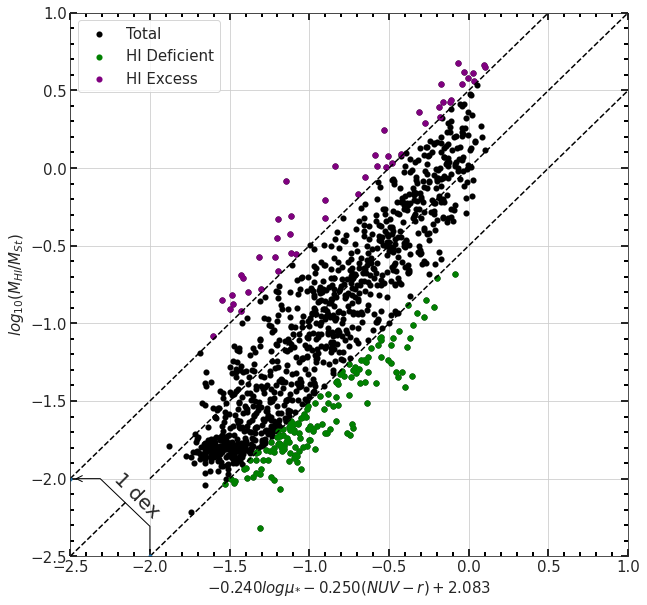

In [110]:
tab_rep = Table.read('data/xGASS_GSWLC.fits')

fig, ax  = plt.subplots(figsize = (10,10))

M        = pow(10,tab_rep['lgMstar'])
R50z     = tab_rep['petrR50_z']
u_        = M/(2*np.pi*R50z**2)
lgu      = np.log10(u_)
lgMH_Mst = tab_rep['lgGF'] 
NUV_r    = tab_rep['NUVr']
tab_rep['lgMH_Mst_pred'] = -0.240*lgu -0.250*NUV_r +2.083

x = tab_rep['lgMH_Mst_pred']
y = lgMH_Mst

ax.scatter(x,y,color = 'black', marker = 'o', linewidth = 0.1, label = 'Total')

x = tab_HI_def['lgMH_Mst_pred']
y = tab_HI_def['lgGF']

img = ax.scatter(x,y, color = 'green',marker = 'o', linewidth = 0.1, vmin = 0.5, vmax = 4.5,
                 label = 'HI Deficient')

x = tab_HI_exc['lgMH_Mst_pred']
y = tab_HI_exc['lgGF']

img = ax.scatter(x,y, color = 'purple',marker = 'o', linewidth = 0.1,vmin = 0.5, vmax = 4.5,
                 label = 'HI Excess')

x= np.linspace(-2.5,1)

x= np.linspace(-2.5,1)
y=x
x= np.where( (x>-2.1)&(x<-2.05),np.nan,x)

ax.plot(x,y,'--', color = 'black')

x = np.linspace(-2.5,1) 
y = x + 0.5
ax.plot(x,y,'--', color = 'black')

x = np.linspace(-2.5,1) 
y = x - 0.5
ax.plot(x,y,'--', color = 'black')
ax.set_xlabel(r'$-0.240log\mu_{*} -0.250(NUV-r) +2.083$')
ax.set_ylabel(r'$log_{10}(M_{HI}/M_{St})$')
ax.set_ylim(-2.5,1)
ax.set_xlim(-2.5,1)
demo_con_style(ax, "arc,angleA=-90,angleB=0,armA=-30,armB=30,rad=0")

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', width=2,direction="in", top = True,right = True,
               bottom = True, left = True)
ax.tick_params(which='major', length=7,direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")
ax.grid()
ax.legend()
#fig.suptitle('HI Scaling relation using NUV-r', y = 0.92)

In [35]:
plt.rcParams['text.usetex'] = False

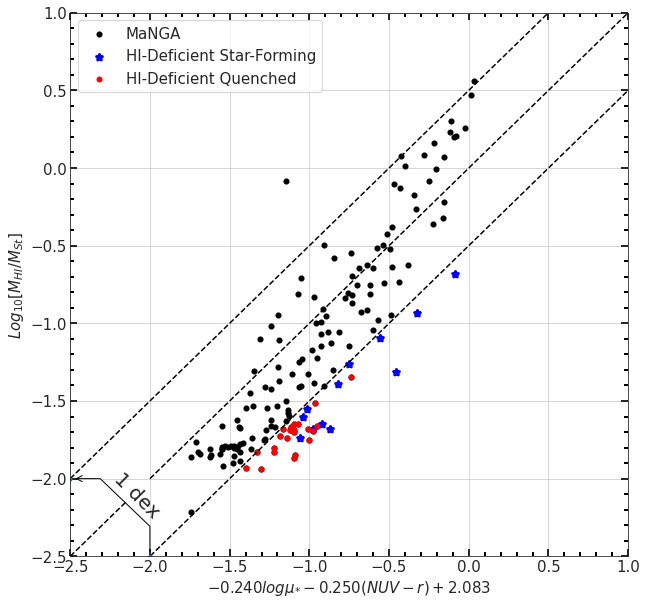

In [111]:
fig, ax  = plt.subplots(figsize = (10,10))

tab_rep_M = Table.read('data/xGASS_MaNGA_GSWLC.fits')

M        = pow(10,tab_rep_M['lgMstar'])
R50z     = tab_rep_M['petrR50_z']
u_        = M/(2*np.pi*R50z**2)
lgu      = np.log10(u_)
lgMH_Mst = tab_rep_M['lgGF'] 
NUV_r    = tab_rep_M['NUVr']
tab_rep_M['lgMH_Mst_pred'] = -0.240*lgu -0.250*NUV_r +2.083

x = tab_rep_M['lgMH_Mst_pred']
y = lgMH_Mst

cmap = colors.ListedColormap(['red','blue','orange','green'])

ax.scatter(x,y,color = 'black', marker = 'o', linewidth = 0.1, label = 'MaNGA')

x = df_SF['lgMH_Mst_pred']
y = df_SF['lgGF']

img = ax.scatter(x,y, color = 'blue',marker = '*', linewidth = 3, vmin = 0.5, vmax = 4.5,
                 label = 'HI-Deficient Star-Forming')

x = df_noSF['lgMH_Mst_pred']
y = df_noSF['lgGF']

img = ax.scatter(x,y, color = 'red',marker = '.', linewidth = 3,vmin = 0.5, vmax = 4.5,
                 label = 'HI-Deficient Quenched')

x= np.linspace(-2.5,1)

x= np.linspace(-2.5,1)
y=x
x= np.where( (x>-2.1)&(x<-2.05),np.nan,x)

ax.plot(x,y,'--', color = 'black')

x = np.linspace(-2.5,1) 
y = x + 0.5
ax.plot(x,y,'--', color = 'black')

x = np.linspace(-2.5,1) 
y = x - 0.5
ax.plot(x,y,'--', color = 'black')
ax.set_xlabel(r'$-0.240log\mu_{*} -0.250(NUV-r) +2.083$')
ax.set_ylabel(r'$Log_{10}[M_{HI}/M_{St}]$')
ax.set_ylim(-2.5,1)
ax.set_xlim(-2.5,1)
demo_con_style(ax, "arc,angleA=-90,angleB=0,armA=-30,armB=30,rad=0")

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', width=2,direction="in", top = True,right = True,
               bottom = True, left = True)
ax.tick_params(which='major', length=7,direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")
ax.grid()
ax.legend()

#fig.suptitle('HI Scaling relation using NUV-r', y = 0.92)

### **HI-Deficient**

In [112]:
tab_rep['HI_Def'] = tab_rep['lgMH_Mst_pred'] - tab_rep['lgGF']
tab_HI_def = tab_rep[tab_rep['HI_Def'] >=0.5]
tab_HI_exc = tab_rep[tab_rep['HI_Def'] <=-0.5]

tab_rep_M['HI_Def'] = tab_rep_M['lgMH_Mst_pred'] - tab_rep_M['lgGF']
tab_HI_def_M = tab_rep_M[tab_rep_M['HI_Def'] >=0.5]

#### **Star-Forming**

In [47]:
ids = ['1-456339','1-456772','1-457009', '1-116725','1-53952', '1-335441', 
       '1-117014', '1-389509', '1-298482', '1-42704', '1-298715', '1-42718']
ids_ = ['1-623756', '1-591260', '1-457175', '1-456698', '1-457185', '1-404358',
        '1-456399', '1-335271','1-384400', '1-82382', '1-115158', '1-115334',
        '1-115435', '1-117543', '1-83393', '1-115377', '1-42274', '1-230042',
        '1-42184', '1-78688', '1-120103', '1-119212']

In [48]:
len(ids), len(ids_)

(12, 22)

In [49]:
tab = Table.read('data/xGASS_MaNGA_GSWLC.fits')
p = []
for i in tab['plateifu']:
  p.append(i.split()[0])

m = []
for i in tab['mangaid']:
  m.append(i.split()[0])

df = tab[['plateifu','mangaid','RA_1', 'Dec_1', 'zSDSS','Dlum','lgMstar', 
                          'petrR50_r','petrR90_r', 'petrR50_z', 'lgmust',
                          'lgM', 'lgssfr', 'NUVr', 
                          'lgSFR_tot_median', 'SFR_best', 
                          'SFRerr_best', 'SFRcase_best', 
                          'zHI','W50cor', 'lgMHI', 'lgGF',
                          'weight', 'Ngal_B', 'logMh_Mst_B',
                          'lvir_ratB','HIsrc']].to_pandas()
df['plateifu'] = p
df['mangaid']  = m

In [50]:
df_SF = df[0:0]
for i in ids:
  df_SF = df_SF.append(df[df['mangaid']==i])

In [ ]:
df_SF

Text(0.5, 0.92, 'HI Deficient Galaxies in MaNGA DR17')

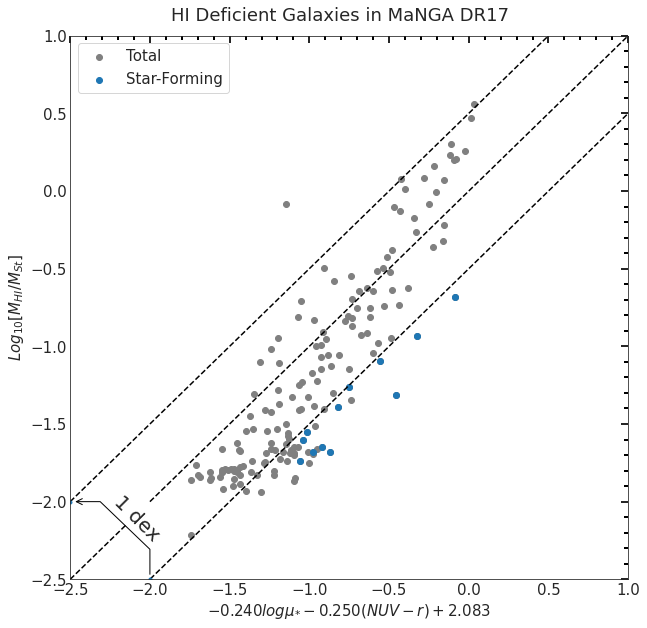

In [52]:
fig, ax  = plt.subplots(figsize = (10,10))

M        = pow(10,df['lgMstar'])
R50z     = df['petrR50_z']
u_       = M/(2*np.pi*R50z**2)
lgu      = np.log10(u_)
lgMH_Mst = df['lgGF'] 
NUV_r    = df['NUVr']
df['lgMH_Mst_pred'] = -0.240*lgu -0.250*NUV_r +2.083

x = df['lgMH_Mst_pred']
y = lgMH_Mst

ax.scatter(x,y,color = 'grey', label = 'Total')

M        = pow(10,df_SF['lgMstar'])
R50z     = df_SF['petrR50_z']
u_        = M/(2*np.pi*R50z**2)
lgu      = np.log10(u_)
lgMH_Mst = df_SF['lgGF'] 
NUV_r    = df_SF['NUVr']

df_SF['lgMH_Mst_pred'] = -0.240*lgu -0.250*NUV_r +2.083

x = df_SF['lgMH_Mst_pred']
y = lgMH_Mst

z = []

img = ax.scatter(x,y,label = 'Star-Forming')

x= np.linspace(-2.5,1)
y=x
x= np.where( (x>-2.1)&(x<-2.05),np.nan,x)

ax.plot(x,y,'--', color = 'black')

x = np.linspace(-2.5,1) 
y = x + 0.5
ax.plot(x,y,'--', color = 'black')

x = np.linspace(-2.5,1) 
y = x - 0.5
ax.plot(x,y,'--', color = 'black')
ax.set_xlabel(r'$-0.240log\mu_{*} -0.250(NUV-r) +2.083$')
ax.set_ylabel(r'$Log_{10}[M_{HI}/M_{St}]$')
ax.set_ylim(-2.5,1)
ax.set_xlim(-2.5,1)
demo_con_style(ax, "arc,angleA=-90,angleB=0,armA=-30,armB=30,rad=0")


ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', width=2,direction="in", top = True,right = True)
ax.tick_params(which='major', length=7,direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")
ax.legend()
fig.suptitle('HI Deficient Galaxies in MaNGA DR17', y = 0.92)

In [53]:
df['HI_Def'] = df['lgMH_Mst_pred'] - df['lgGF']
df_HI_def    = df[df['HI_Def']>=0.5]
s_cl = []

for i in df_HI_def.lgssfr:
  if i<-11.8:
    s_cl.append(0)
  elif i>=-11.8 and i< -10.8:
    s_cl.append(1)
  elif i>=-10.8:
    s_cl.append(2)
df_HI_def['SFR_class'] = s_cl
df_SF = df[0:0]
for i in ids:
  df_SF = df_SF.append(df_HI_def[df_HI_def['mangaid']==i])

[WARNING]:  (SettingWithCopyWarning)
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_HI_def['SFR_class'] = s_cl



In [54]:
df_SF.keys()

Index(['plateifu', 'mangaid', 'RA_1', 'Dec_1', 'zSDSS', 'Dlum', 'lgMstar',
       'petrR50_r', 'petrR90_r', 'petrR50_z', 'lgmust', 'lgM', 'lgssfr',
       'NUVr', 'lgSFR_tot_median', 'SFR_best', 'SFRerr_best', 'SFRcase_best',
       'zHI', 'W50cor', 'lgMHI', 'lgGF', 'weight', 'Ngal_B', 'logMh_Mst_B',
       'lvir_ratB', 'HIsrc', 'lgMH_Mst_pred', 'HI_Def', 'SFR_class'],
      dtype='object')

In [55]:
df_SF[['plateifu','mangaid', 'RA_1','Dec_1','zSDSS','NUVr', 'lgMstar','lgMHI','HI_Def','SFR_class']]

,plateifu,mangaid,RA_1,Dec_1,zSDSS,NUVr,lgMstar,lgMHI,HI_Def,SFR_class
33,11014-12705,1-456339,194.476520,27.490639,0.016611,4.82,9.807007,8.126,0.808111,2.0
42,8934-3701,1-456772,194.025420,27.678109,0.016483,1.69,9.118738,8.437,0.595712,2.0
54,8934-6102,1-457009,196.046870,27.490445,0.017770,4.57,9.926116,8.277,0.729663,2.0
75,12083-12705,1-116725,344.361230,13.001654,0.025680,4.54,10.556000,9.003,0.540812,2.0
122,9512-9102,1-53952,140.138670,0.721037,0.017200,3.14,9.018043,8.082,0.609671,2.0
142,11967-1901,1-335441,231.947610,9.624913,0.031190,3.99,10.569000,8.965,0.562829,2.0
21,12085-6103,1-117014,345.929430,13.926541,0.027060,3.44,10.405000,9.012,0.575059,2.0
126,8150-6104,1-389509,147.539000,33.569333,0.027030,4.46,10.611000,8.872,0.679786,1.0
50,9495-6101,1-298482,122.550740,22.772292,0.015594,4.38,9.366620,8.102,0.515602,1.0
4,9195-6102,1-42704,27.653678,13.110230,0.016488,3.40,9.249792,7.939,0.856875,2.0


#### **Quenched**

In [56]:
df_noSF = df_HI_def[0:0]

for i  in df_HI_def['mangaid'].values:
  if i not in ids:
    df_noSF = df_noSF.append(df_HI_def[df_HI_def['mangaid']==i])

In [57]:
df_noSF[['plateifu','mangaid', 'RA_1','Dec_1','zSDSS','NUVr', 'lgMstar','lgMHI','HI_Def','lgssfr','SFR_class']]

,plateifu,mangaid,RA_1,Dec_1,zSDSS,NUVr,lgMstar,lgMHI,HI_Def,lgssfr,SFR_class
0,8087-9101,1-119212,356.692320,16.043083,0.041620,5.16,11.309000,9.375,0.537392,-11.430,1
11,9863-6104,1-623756,195.288470,27.818327,0.019749,5.26,10.048184,8.324,0.537279,-12.010,0
16,9509-12703,1-230042,124.105670,25.991356,0.045270,4.13,11.320000,9.470,0.761577,-11.650,1
30,9863-12704,1-591260,195.068820,27.967522,0.015470,4.51,9.799283,8.106,0.714455,-12.390,0
31,10517-3703,1-78688,150.264040,4.619273,0.013501,5.06,9.662399,7.979,0.676680,-12.060,0
55,7978-6104,1-115377,333.590720,13.953097,0.026110,4.93,10.781000,8.976,0.585749,-11.390,1
61,9874-9102,1-404358,194.612210,29.612479,0.019469,5.36,10.044857,8.357,0.563732,-13.090,0
62,9880-12702,1-457185,195.646580,27.439437,0.018061,4.34,9.407500,8.065,0.604777,-9.652,2
64,12506-6102,1-82382,218.579250,3.664377,0.033570,4.13,11.037000,9.386,0.556331,-11.250,1
78,11968-12704,1-335271,229.764110,8.138726,0.033770,4.77,11.123000,9.294,0.607629,-11.270,1


In [59]:
import matplotlib.patches as  mpatches

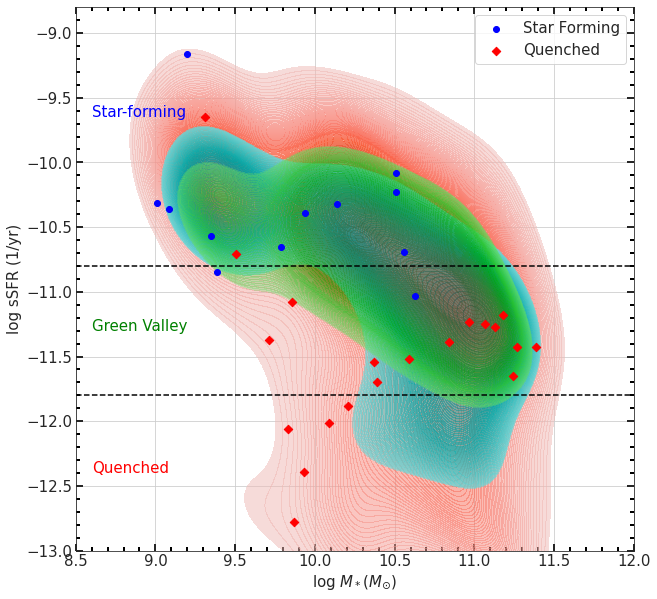

In [74]:
fig, ax  = plt.subplots()

x = df_SF['lgM']
y = df_SF['lgssfr']
ax.scatter(x,y, marker = 'o', zorder = 101, color = 'blue')

x = df_noSF['lgM']
y = df_noSF['lgssfr']
ax.scatter(x,y, marker = 'D', zorder = 101, color = 'red')

x = tab_rep['lgM'].value
y = tab_rep['lgssfr'].value

x = np.where(x<7,np.nan, x)

x = x.astype('float')
y = y.astype('float')
sb.kdeplot(x=x,y=y, fill = True, levels = 100, ax = ax, color = 'salmon', 
           legend  = True,alpha = 0.5)

x = tab_rep_M['lgM'].value
y = tab_rep_M['lgssfr'].value

x = x.astype('float')
y = y.astype('float')
sb.kdeplot(x=x,y=y, fill = True,levels = np.linspace(0.5,1,100), ax = ax, 
           color ='cyan', alpha = 0.5)

x = tab_HI_def['lgM'].value
y = tab_HI_def['lgssfr'].value


x = np.where(x<7,np.nan, x)

x = x.astype('float')
y = y.astype('float')

sb.kdeplot(x=x,y=y, fill = True,levels = np.linspace(0.5,1,100), ax = ax, 
           color ='green', alpha = 0.3
           )

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', width=2,direction="in", top = True,right = True,
               bottom = True, left = True)
ax.tick_params(which='major', length=7,direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")

ax.set_ylim(-13,-8.8)
ax.set_xlim(8.5,12)
ax.plot([8.5,13], [-10.8,-10.8], '--', color = 'black',label = '_nolegend_')

ax.plot([8.5,13], [-11.8,-11.8], '--', color = 'black',label = '_nolegend_')
ax.set_xlabel(r'log $M_*(M_{\odot})$')
ax.set_ylabel('log sSFR (1/yr)')


ax.legend(['Star Forming','Quenched'])
ax.annotate('Star-forming',(8.6,-9.65), color = 'blue')
ax.annotate('Green Valley',(8.6,-11.3), color = 'green')
ax.annotate('Quenched',(8.6,-12.4), color = 'red')
ax.grid()

In [75]:
t_dep_SF = (df_SF['lgMHI'].values-(df_SF['lgssfr'] + df_SF['lgM']))

t_dep_SF = np.log10((2.3/0.6)*pow(10,t_dep_SF ))

In [76]:
t_dep_noSF = (df_noSF['lgMHI'].values- (df_noSF['lgssfr'] + df_noSF['lgM']))


t_dep_noSF = np.log10((2.3/0.6)*pow(10,t_dep_noSF ))

In [ ]:
#t_dep_SF_m = (df_SF['lgMHI'].values-np.log10(df_SF['SFR_m']))

#t_dep_SF_m = np.log10((2.3/0.6)*pow(10,t_dep_SF_m))

In [ ]:
#t_dep_noSF_m = (df_noSF['lgMHI'].values-np.log10(df_noSF['SFR_m']))

#t_dep_noSF_m = np.log10((2.3/0.6)*pow(10,t_dep_noSF_m))

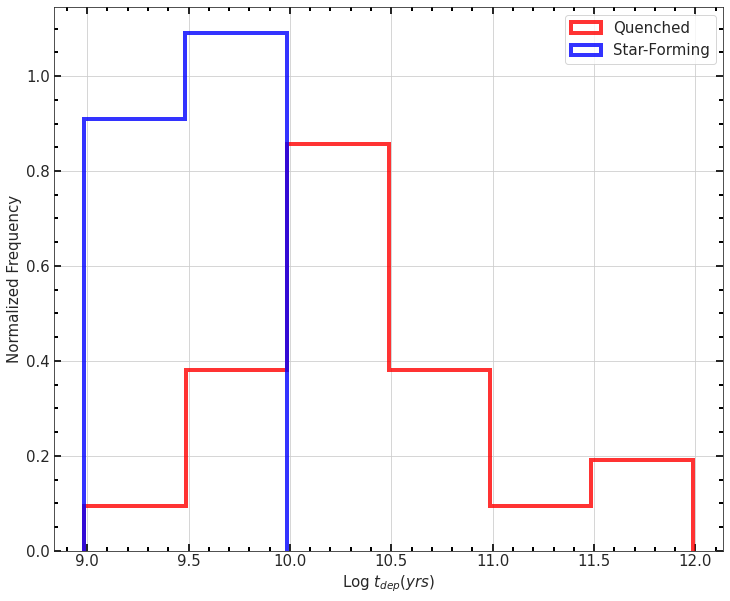

In [77]:
step = 0.5

fig, ax = plt.subplots(figsize = (12,10))

bins = np.arange(t_dep_noSF.min(),t_dep_noSF.max(),step)
ax.hist(t_dep_noSF, bins = bins,  histtype = 'step', density = True, 
         linewidth = 4, color = 'red', alpha = 0.8)

bins = np.arange(t_dep_SF.min(),t_dep_SF.max(), step)
ax.hist(t_dep_SF, bins = bins,  histtype = 'step', density = True, 
         linewidth = 4, color = 'blue', alpha = 0.8)

ax.legend(['Quenched', 'Star-Forming'])
ax.set_xlabel(r'Log $t_{dep} (yrs)$')
ax.set_ylabel('Normalized Frequency')
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', width=2,direction="in", top = True,right = True,
               bottom = True, left = True)
ax.tick_params(which='major', length=7,direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")
ax.grid(True)

In [ ]:
step = 0.5

fig, ax = plt.subplots(figsize = (12,10))

bins = np.arange(t_dep_noSF_m.min(),t_dep_noSF_m.max(),step)
ax.hist(t_dep_noSF_m.values, bins = bins,  histtype = 'step', density = True, 
         linewidth = 4, color = 'red', alpha = 0.8)

bins = np.arange(t_dep_SF_m.min(),t_dep_SF_m.max(), step)
ax.hist(t_dep_SF_m, bins = bins,  histtype = 'step', density = True, 
         linewidth = 4, color = 'blue', alpha = 0.8)

ax.legend(['Quenched', 'Star-Forming'])
ax.set_xlabel(r'Log $t_{dep} (yrs)$')
ax.set_ylabel('Normalized Frequency')
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', width=2,direction="in", top = True,right = True,
               bottom = True, left = True)
ax.tick_params(which='major', length=7,direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")
ax.grid(True)

In [ ]:
bins

In [86]:
!wget https://data.sdss.org/sas/dr17/manga/photo/pymorph/1.1.1/manga-pymorph-DR17.fits

--2023-01-31 15:21:18--  https://data.sdss.org/sas/dr17/manga/photo/pymorph/1.1.1/manga-pymorph-DR17.fits
Resolving data.sdss.org (data.sdss.org)... 155.101.19.31
Connecting to data.sdss.org (data.sdss.org)|155.101.19.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13878720 (13M) [application/octet-stream]
Saving to: ‘manga-pymorph-DR17.fits’

manga-pymorph-DR17. 100%[===================>]  13.24M  1.35MB/s    in 9.9s    

2023-01-31 15:21:29 (1.34 MB/s) - ‘manga-pymorph-DR17.fits’ saved [13878720/13878720]



In [144]:
hdul = fits.open('manga-pymorph-DR17.fits')
tab_pym_g    = Table.read(hdul[1])
tab_pym_r    = Table.read(hdul[2])
tab_pym_i    = Table.read(hdul[3])

In [145]:
tab_pym_g.rename_column('MANGA_ID', 'mangaid')
tab_pym_r.rename_column('MANGA_ID', 'mangaid')
tab_pym_i.rename_column('MANGA_ID', 'mangaid')

(array([0.30042859, 0.25120973, 0.16369418, 0.11682566, 0.08184709,
        0.05779068, 0.02820406]),
 array([0.1, 1.1, 2.1, 3.1, 4.1, 5.1, 6.1, 7.1]),
 <a list of 7 Patch objects>)

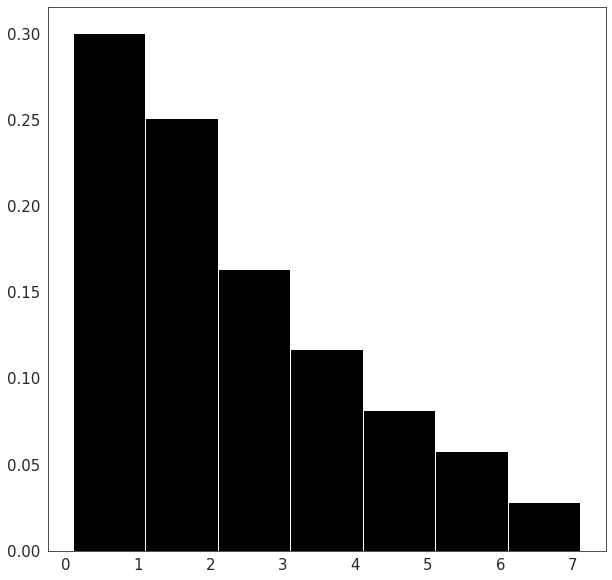

In [146]:
N = []
for row in tab_pym_i:
  R_b = row['A_HL_SE_BULGE']
  R_d = row['A_HL_SE_DISK']
  if R_b<R_d: 
    N.append(row['N_SE_BULGE'])

data = np.array(N)

bins = np.arange(data.min(), data.max(), 1)
plt.hist(data, bins = bins, density = True, color = 'black')

In [147]:
m = []
for i in tab_rep_M['mangaid']:
  m.append(i.split()[0])

tab_rep_M['mangaid'] = m

In [148]:
tab_comb_g = join(tab_rep_M, tab_pym_g, keys = ['mangaid'] )
tab_comb_r = join(tab_rep_M, tab_pym_r, keys = ['mangaid'] )
tab_comb_i = join(tab_rep_M, tab_pym_i, keys = ['mangaid'] )

In [149]:
cl = []
for i in tab_comb_g['mangaid']:
  if i.split()[0] in ids:
    cl.append(1)
  elif i.split()[0] in ids_:
    cl.append(2)
  else:
    cl.append(0)

In [150]:
tab_comb_g['SF_class'] = cl
tab_comb_r['SF_class'] = cl
tab_comb_i['SF_class'] = cl

In [151]:
MPP_main = tab_comb_i.copy()
MPP_main.remove_columns(['nsa_sersic_absmag', 'nsa_elpetro_absmag', 'nsa_elpetro_amivar', 'nsa_extinction', 'nsa_petro_flux', 'nsa_petro_flux_ivar', 'nsa_elpetro_flux', 'nsa_elpetro_flux_ivar', 'nsa_sersic_flux', 'nsa_sersic_flux_ivar'])

In [152]:
MPP_main = MPP_main.to_pandas()

In [153]:
MPP_n = MPP_main[0:0]
for i,row in MPP_main.iterrows():
  R_b = row['A_HL_SE_BULGE']
  R_d = row['A_HL_SE_DISK']
  if R_b<R_d: 
    MPP_n = MPP_n.append(row)

Text(0, 0.5, 'Normalized Frequency')

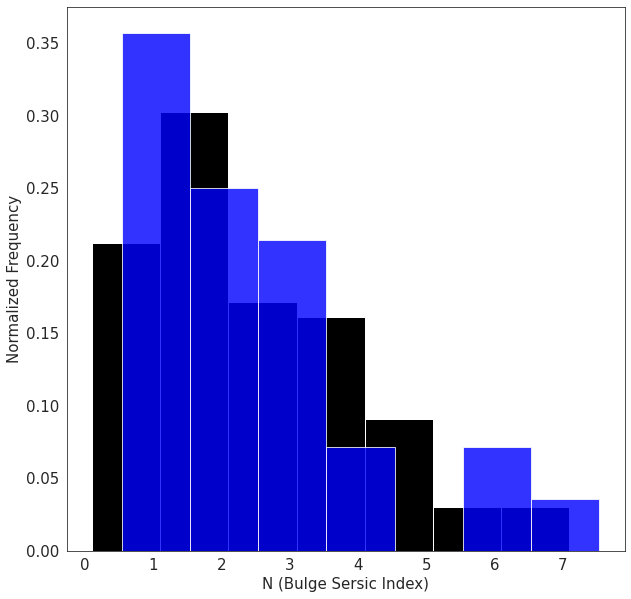

In [154]:
data = MPP_n[(MPP_n['SF_class']==0)]['N_SE_BULGE']

bins = np.arange(data.min(), data.max(), 1)
plt.hist(data, bins = bins, density = True, color = 'black')
data = MPP_n[(MPP_n['SF_class']==1) | (MPP_n['SF_class']==2)]['N_SE_BULGE']

bins = np.arange(data.min(), data.max(), 1)
plt.hist(data, bins = bins, density = True, alpha = 0.8, color = 'blue')
plt.xlabel('N (Bulge Sersic Index)')
plt.ylabel('Normalized Frequency')

In [155]:
for i in ids:
  row = tab_comb_g[tab_comb_g['mangaid']==i]
  if row['FLAG_FIT'] == 2 or row['FLAG_FIT'] == 0:

    R_e   = row ['A_HL_SE_BULGE'].value
    g_b   = row['M_SE_BULGE'].value[0]
    g_d   = row['M_SE_DISK'].value[0]
    mu_e  = row['M_SE_BULGE'].value + 2.5*np.log10(2*np.pi*R_e**2) 
    mu_e += 2.5*np.log10(row['BA_SE_BULGE']) -  10*np.log10(1 + row['Z'])
    n_e   = row['N_SE_BULGE'].value

    R_e   = np.round(R_e,2)
    mu_e   = np.round(mu_e,2)
    n_e   = np.round(n_e,2)

    R_d   = row['A_HL_SE_DISK'].value/( 1.9992*row['N_SE_DISK'].value - 0.3271)
    mu_d  = row['M_SE_DISK'].value + 2.5*np.log10(2*np.pi*R_d**2) 
    mu_d += 2.5*np.log10(row['BA_SE_DISK']) -  10*np.log10(1 + row['Z'])
    n_d   = row['N_SE_DISK'].value

    R_d   = np.round(R_d,2)
    mu_d   = np.round(mu_d,2)
    n_d   = np.round(n_d,2)

    if R_e>R_d:
      temp = R_e
      R_e = R_d
      R_d = temp

      temp = mu_e
      mu_e = mu_d
      mu_d = temp

      temp = n_e
      n_e = n_d
      n_d = temp

      temp = g_b
      g_b  = g_d
      g_d  = temp
  
  else : 
    R_e   = '-'
    mu_e  = '-'
    n_e   = '-'

    R_d   = row['A_HL_S'].value/( 1.9992*row['N_S'].value - 0.3271)
    mu_d  = row['M_S'].value + 2.5*np.log10(2*np.pi*R_d**2) 
    mu_d += 2.5*np.log10(row['BA_S']) -  10*np.log10(1 + row['Z'])
    n_d   = row['N_S'].value

    R_d   = np.round(R_d,2)
    mu_d   = np.round(mu_d,2)
    n_d   = np.round(n_d,2)

  print(f"{row['mangaid'].value[0]} ",   end = ' & ')
  print(f'{mu_e[0]} & {R_e[0]} & {n_e[0]} & {mu_d[0]} & {R_d[0]} & {n_d[0]} &', end = ' ')


  row = tab_comb_i[tab_comb_i['mangaid']==i]
  if row['FLAG_FIT'] == 2 or row['FLAG_FIT'] == 0:

    R_e   = row ['A_HL_SE_BULGE'].value
    i_b   = row['M_SE_BULGE'].value[0]
    i_d   = row['M_SE_DISK'].value[0]
    mu_e  = row['M_SE_BULGE'].value + 2.5*np.log10(2*np.pi*R_e**2) 
    mu_e += 2.5*np.log10(row['BA_SE_BULGE']) -  10*np.log10(1 + row['Z'])
    n_e   = row['N_SE_BULGE'].value

    R_e   = np.round(R_e,2)
    mu_e   = np.round(mu_e,2)
    n_e   = np.round(n_e,2)

    R_d   = row['A_HL_SE_DISK'].value/( 1.9992*row['N_SE_DISK'].value - 0.3271)
    mu_d  = row['M_SE_DISK'].value + 2.5*np.log10(2*np.pi*R_d**2) 
    mu_d += 2.5*np.log10(row['BA_SE_DISK']) -  10*np.log10(1 + row['Z'])
    n_d   = row['N_SE_DISK'].value

    R_d   = np.round(R_d,2)
    mu_d   = np.round(mu_d,2)
    n_d   = np.round(n_d,2)

    if R_e>R_d:
      temp = R_e
      R_e  = R_d
      R_d  = temp

      temp = mu_e
      mu_e = mu_d
      mu_d = temp

      temp = n_e
      n_e  = n_d
      n_d  = temp

      temp = i_b
      i_b  = i_d
      i_d  = temp
  
  else : 
    R_e   = '-'
    mu_e  = '-'
    n_e   = '-'

    R_d   = row['A_HL_S'].value/( 1.9992*row['N_S'].value - 0.3271)
    mu_d  = row['M_S'].value + 2.5*np.log10(2*np.pi*R_d**2) 
    mu_d += 2.5*np.log10(row['BA_S']) -  10*np.log10(1 + row['Z'])
    n_d   = row['N_S'].value

    R_d   = np.round(R_d,2)
    mu_d   = np.round(mu_d,2)
    n_d   = np.round(n_d,2)


  g_i_b = np.round(g_b-i_b,2)
  g_i_d = np.round(g_d-i_d,2)
  print(f'{mu_e[0]} & {R_e[0]} & {n_e[0]} & {mu_d[0]} & {R_d[0]} & {n_d[0]} & {g_i_b} &{g_i_d} \\\\')

1-456339  & 20.65 & 4.22 & 1.0 & 22.22 & 7.76 & 5.6 & 19.7 & 4.43 & 1.0 & 21.12 & 7.7 & 5.9 & 1.0 &1.19 \\
1-456772  & - & - & - & 18.23 & 1.94 & 1.11 & - & - & - & 17.81 & 2.03 & 1.15 & 1.0 &1.19 \\
1-457009  & 18.05 & 0.39 & 0.94 & 20.72 & 3.98 & 1.0 & 17.12 & 0.49 & 2.1 & 19.63 & 3.9 & 1.0 & 1.27 &1.08 \\
1-116725  & 20.94 & 4.9 & 1.0 & 21.92 & 7.92 & 1.92 & 18.61 & 1.59 & 2.15 & 18.74 & 4.05 & 1.0 & -0.35 &1.86 \\
1-53952  & - & - & - & 21.91 & 4.12 & 1.11 & - & - & - & 21.04 & 4.04 & 1.1 & -0.35 &1.86 \\
1-335441  & 19.64 & 2.39 & 0.8 & 20.4 & 3.21 & 1.0 & 18.06 & 2.15 & 1.1 & 19.35 & 3.16 & 1.0 & 1.25 &1.09 \\
1-117014  & - & - & - & 18.27 & 2.39 & 1.51 & - & - & - & 16.44 & 1.82 & 1.81 & 1.25 &1.09 \\
1-389509  & 18.73 & 1.4 & 5.36 & 20.52 & 5.23 & 1.0 & 18.44 & 2.69 & 5.97 & 19.76 & 5.66 & 1.0 & 1.73 &0.93 \\
1-298482  & - & - & - & 19.46 & 2.16 & 1.71 & - & - & - & 18.41 & 2.25 & 1.71 & 1.73 &0.93 \\
1-42704  & - & - & - & 20.4 & 2.37 & 1.18 & - & - & - & 19.28 & 2.32 & 1.33 &

(array([0.03418803, 0.        , 0.        , ..., 0.05982906, 0.01709402,
        0.03418803]),
 array([-999., -998., -997., ...,    5.,    6.,    7.]),
 <a list of 1 Patch objects>)

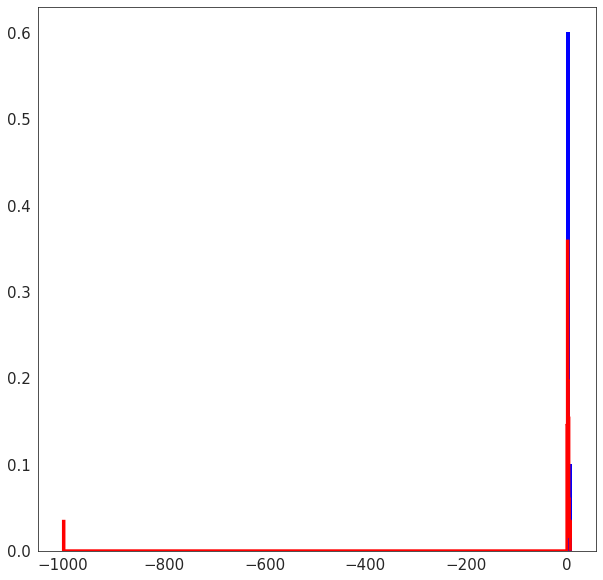

In [156]:
fig, ax  = plt.subplots()

data = tab_comb_g[tab_comb_g['SF_class']==1]['N_SE_BULGE']
bins = np.arange(data.min(),data.max(),1)
ax.hist(data, bins = bins, histtype = 'step', color = 'blue' , density = True ,
        linewidth = 3)

data = tab_comb_g[tab_comb_g['SF_class']==0]['N_SE_BULGE']
bins = np.arange(data.min(),data.max(),1)
plt.hist(data, bins = bins, histtype = 'step', color = 'red' , density = True,
         linewidth = 3)

In [105]:
tab_comb_g['lgssfr'] = tab_comb_g['SFR_best'] - tab_comb_g['lgMstar']

In [ ]:
fig, ax  = plt.subplots()

tab = tab_comb_g
s_cl = []
for i in tab['lgssfr']:
  if i<-11.8:
    s_cl.append(0)
  elif i>=-11.8 and i< -10.8:
    s_cl.append(1)
  elif i>=-10.8:
    s_cl.append(2)
tab['SF_class'] = s_cl

data = tab[tab['SF_class']==0]['N_SE_BULGE']
bins = np.arange(0,data.max(),1)
ax.hist(data, bins = bins, histtype = 'step', color = 'red' , density = True ,
        linewidth = 3)

data = tab[tab['SF_class']==1]['N_SE_BULGE']
bins = np.arange(0,data.max(),1)
ax.hist(data, bins = bins, histtype = 'step', color = 'green' , density = True ,
        linewidth = 3)
data = tab[tab['SF_class']==2]['N_SE_BULGE']
bins = np.arange(0,data.max(),1)
ax.hist(data, bins = bins, histtype = 'step', color = 'blue' , density = True ,
        linewidth = 3)



### **Density**

In [ ]:
tab_rep_D = Table.read('data/xGASS_Baldry.fits')

fig, ax  = plt.subplots(figsize = (12,10))

M        = pow(10,tab_rep_D['lgMstar'])
R50z     = tab_rep_D['petrR50_z']
u_        = M/(2*np.pi*R50z**2)
lgu      = np.log10(u_)
lgMH_Mst = tab_rep_D['lgGF'] 
NUV_r    = tab_rep_D['NUVr']
tab_rep_D['lgMH_Mst_pred'] = -0.240*lgu -0.250*NUV_r +2.083

x_ = tab_rep_D['lgMH_Mst_pred'].value
y_ = tab_rep_D['lgGF'] 

img = ax.scatter(x_,y_,c= tab_rep['density'], cmap = 'hsv')
plt.colorbar(img, label = 'Log(Density)')
x= np.linspace(-2.5,1)
y=x
x= np.where( (x>-2.1)&(x<-2.05),np.nan,x)

ax.plot(x,y,'--', color = 'black')

x = np.linspace(-2.5,1) 
y = x + 0.5
ax.plot(x,y,'--', color = 'black')

x = np.linspace(-2.5,1) 
y = x - 0.5
ax.plot(x,y,'--', color = 'black')
ax.set_xlabel(r'$-0.240log\mu_{*} -0.250(NUV-r) +2.083$')
ax.set_ylabel(r'$Log_{10}[M_{HI}/M_{St}]$')
ax.set_ylim(-2.5,1)
ax.set_xlim(-2.5,1)
demo_con_style(ax, "arc,angleA=-90,angleB=0,armA=-30,armB=30,rad=0")


ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', width=2,direction="in", top = True,right = True)
ax.tick_params(which='major', length=7,direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")
fig.suptitle('HI Scaling relation using NUV-r', y = 0.92)

In [ ]:
fig, ax  = plt.subplots(figsize = (12,10))
z = []

for i in tab_rep['density']:
  if i<-0.5:
    z.append(-1)
  elif i>=-0.5 and i<=0.5:
    z.append(0)
  elif i>0.5:
    z.append(1)
z = np.array(z)
cmap = colors.ListedColormap(['red', 'green', 'blue'])
img = ax.scatter(x_,y_,c=z , cmap = cmap, vmin = -1.5,vmax =1.5 
                 , label = '_nolegend_')

cb = plt.colorbar(img, label = r"log $\Sigma$")
cb.set_ticks([-1,0,1])
cb.ax.set_yticklabels(['Low','Intermediate','High'], rotation = 90)
x= np.linspace(-2.5,1)
y=x
x= np.where( (x>-2.1)&(x<-2.05),np.nan,x)

ax.plot(x,y,'--', color = 'black', label = '_nolegend_')

x = np.linspace(-2.5,1) 
y = x + 0.5
ax.plot(x,y,'--', color = 'black', label = '_nolegend_')

x = np.linspace(-2.5,1) 
y = x - 0.5
ax.plot(x,y,'--', color = 'black', label = '_nolegend_')
ax.set_xlabel(r'$-0.240log\mu_{*} -0.250(NUV-r) +2.083$')
ax.set_ylabel(r'$Log_{10}[M_{HI}/M_{St}]$')
ax.set_ylim(-2.5,1)
ax.set_xlim(-2.5,1)
demo_con_style(ax, "arc,angleA=-90,angleB=0,armA=-30,armB=30,rad=0")

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', width=2,direction="in", top = True,right = True)
ax.tick_params(which='major', length=7,direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")
fig.suptitle('HI Scaling relation using NUV-r', y = 0.92)

In [ ]:
tab_rep

In [ ]:
tab_rep_D

In [ ]:
tab_GS_D = join(tab_HI_def, tab_rep_D, keys = 'SDSS' )

In [ ]:
x = tab_GS_D['lgM'].value
y = tab_GS_D['lgssfr'].value

x = np.where(x<7,np.nan, x)

x = x.astype('float')
y = y.astype('float')
z = []
for i in tab_GS_D['density']:
  if i<-0.5:
    z.append('Low')
  elif i>=-0.5 and i<=0.5:
    z.append('Inter')
  elif i>0.5:
    z.append('High')
z = np.array(z)

g = sb.jointplot( x=x, y=y, hue = z,  marker="o", palette={
                          'Low': 'blue',
                          'Inter': 'green',
                          'High':'red'
                      },
                  xlim =(8.5,12), ylim = (-8.8,-13))

#cb = plt.colorbar(img, label = r"log $\Sigma$")
#cb.set_ticks([-1,0,1])
#cb.ax.set_yticklabels(['Low','Intermediate','High'], rotation = 90)

In [ ]:
tab_rep = Table.read('data/xGASS_MaNGA_Baldry.fits')['plateifu','mangaid','RA_1', 
                                         'DEC_1', 'zSDSS', 'nsa_sersic_absmag',
                                          'Dlum','lgMstar', 'expAB_r', 'model_r',
                                          'merr_r', 'ext_r', 'petrR50_r',
                                          'petrR90_r', 'petrR50_z', 'lgmust',
                                          'CINDX', 'INCL', 'NUVr', 
                                          'lgSFR_tot_median', 'SFR_best', 
                                          'SFRerr_best', 'SFRcase_best', 
                                          'zHI','W50cor', 'lgMHI', 'lgGF',
                                          'weight','density', 'Ngal_B', 'logMh_Mst_B',
                                          'lvir_ratB']

tab_rep['Sersic_g-i'] = tab_rep['nsa_sersic_absmag'][:,3]- tab_rep['nsa_sersic_absmag'][:,5]
tab_rep.remove_column('nsa_sersic_absmag')

p = []
for i in tab_rep['plateifu']:
  p.append(i.split()[0])

m = []
for i in tab_rep['mangaid']:
  m.append(i.split()[0])


df = tab_rep.to_pandas()
df['plateifu'] = p
df['mangaid'] = m

M        = pow(10,df['lgMstar'])
R50z     = df['petrR50_z']
u        = M/(2*np.pi*R50z**2)
lgu      = np.log10(u)
lgMH_Mst = df['lgGF'] 
NUV_r    = df['NUVr']
df['lgMH_Mst_pred'] = -0.240*lgu -0.250*NUV_r +2.083

df['HI_Def'] = df['lgMH_Mst_pred']-df['lgGF']
df_HI_def = df[df['HI_Def']>=0.5]

ids = ['11014-12705',
       '8934-3701',
       '8934-6102',
       '12083-12705',
       '11967-1901',
       '12085-6103',
        '8150-6104',
        '8939-3701',
        '9195-6102',
        '9495-6101',
        '8096-6101',
        '9512-9102',
        '12087-6103']


df_SF = df[0:0]
for i in ids:
  df_SF = df_SF.append(df[df['plateifu']==i])

df_noSF = df_HI_def[0:0]
for i in df_HI_def['plateifu'].values:
  if i not in ids:
    df_noSF = df_noSF.append(df_HI_def[df_HI_def['plateifu']==i])

In [ ]:
fig, ax  = plt.subplots(figsize = (10,8))

x = df['lgMH_Mst_pred']
y = df['lgGF'] 

ax.scatter(x,y,color = 'grey', label = 'Total')

M        = pow(10,df_SF['lgMstar'])
R50z     = df_SF['petrR50_z']
u_        = M/(2*np.pi*R50z**2)
lgu      = np.log10(u_)
lgMH_Mst = df_SF['lgGF'] 
NUV_r    = df_SF['NUVr']

df_SF['lgMH_Mst_pred'] = -0.240*lgu -0.250*NUV_r +2.083

x = df_SF['lgMH_Mst_pred']
y = lgMH_Mst

z = []

for i in df_SF['density']:
  if i<-0.5:
    z.append(-1)
  elif i>=-0.5 and i<=0.5:
    z.append(0)
  elif i>0.5:
    z.append(1)
z_noSF = z
cmap = colors.ListedColormap(['red', 'green', 'blue'])

img = ax.scatter(x,y, marker = 'D', c = z,cmap = cmap,
                 vmin =-1.5,vmax=1.5,label = 'Star-Forming')
cb = plt.colorbar(img,label = r"log $\Sigma$")
cb.set_ticks([-1,0,1])
cb.ax.set_yticklabels(['Low','Intermediate','High'], rotation = 90)
x= np.linspace(-2.5,1)
y=x
x= np.where( (x>-2.1)&(x<-2.05),np.nan,x)

ax.plot(x,y,'--', color = 'black')

x = np.linspace(-2.5,1) 
y = x + 0.5
ax.plot(x,y,'--', color = 'black')

x = np.linspace(-2.5,1) 
y = x - 0.5
ax.plot(x,y,'--', color = 'black')
ax.set_xlabel(r'$-0.240log\mu_{*} -0.250(NUV-r) +2.083$')
ax.set_ylabel(r'$Log_{10}[M_{HI}/M_{St}]$')
ax.set_ylim(-2.5,1)
ax.set_xlim(-2.5,1)
demo_con_style(ax, "arc,angleA=-90,angleB=0,armA=-30,armB=30,rad=0")


ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', width=2,direction="in", top = True,right = True)
ax.tick_params(which='major', length=7,direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")
ax.legend()
fig.suptitle('HI Deficient Galaxies in MaNGA DR17', y = 0.92)

In [ ]:
fig, ax  = plt.subplots(figsize = (10,8))

x = df['lgMH_Mst_pred']
y = df['lgGF'] 

ax.scatter(x,y,color = 'grey', label = 'Total')

M        = pow(10,df_noSF['lgMstar'])
R50z     = df_noSF['petrR50_z']
u_        = M/(2*np.pi*R50z**2)
lgu      = np.log10(u_)
lgMH_Mst = df_noSF['lgGF'] 
NUV_r    = df_noSF['NUVr']

df_noSF['lgMH_Mst_pred'] = -0.240*lgu -0.250*NUV_r +2.083

x = df_noSF['lgMH_Mst_pred']
y = lgMH_Mst

z = []

for i in df_noSF['density']:
  if i<-0.5:
    z.append(-1)
  elif i>=-0.5 and i<=0.5:
    z.append(0)
  elif i>0.5:
    z.append(1)
z_noSF = z
cmap = colors.ListedColormap(['red', 'green', 'blue'])

img = ax.scatter(x,y, marker = 'D', c = z,cmap = cmap,
                 vmin =-1.5,vmax=1.5,label = 'Non Star-Forming')
cb = plt.colorbar(img,label = r"log $\Sigma$")
cb.set_ticks([-1,0,1])
cb.ax.set_yticklabels(['Low','Intermediate','High'], rotation = 90)
x= np.linspace(-2.5,1)
y=x
x= np.where( (x>-2.1)&(x<-2.05),np.nan,x)

ax.plot(x,y,'--', color = 'black')

x = np.linspace(-2.5,1) 
y = x + 0.5
ax.plot(x,y,'--', color = 'black')

x = np.linspace(-2.5,1) 
y = x - 0.5
ax.plot(x,y,'--', color = 'black')
ax.set_xlabel(r'$-0.240log\mu_{*} -0.250(NUV-r) +2.083$')
ax.set_ylabel(r'$Log_{10}[M_{HI}/M_{St}]$')
ax.set_ylim(-2.5,1)
ax.set_xlim(-2.5,1)
demo_con_style(ax, "arc,angleA=-90,angleB=0,armA=-30,armB=30,rad=0")


ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', width=2,direction="in", top = True,right = True)
ax.tick_params(which='major', length=7,direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")
ax.legend()
fig.suptitle('HI Deficient Galaxies in MaNGA DR17', y = 0.92)

In [ ]:
bins = np.arange(-1.5,2.5,1)
plt.figure(figsize = (10,6))
plt.hist(tab_rep['density'],bins)
plt.xticks([-1,0,1 ],['Low','Intermediate','High'])
plt.ylabel('Counts')
plt.title('Density Distribuition of xGASS')

In [ ]:
bins = np.arange(-1.5,2.5,0.5)
plt.figure(figsize = (10,6))
plt.hist(df_HI_def['density'],bins)
plt.hist(df_noSF['density'],bins, alpha = 0.7)
plt.grid(True)
plt.hist(df_SF['density'],bins, alpha = 0.7)
#plt.xticks([-1,0,1],['Low','Intermediate','High'])
plt.ylabel('Counts')
plt.title('Density Distribuition of xGASS-MaNGA HI Deficient')
plt.legend(['HI-Def','HI-Def no SF','HI-Def SF']);
plt.xlabel(r'$log\Sigma$')

In [ ]:
df_SF[['plateifu','mangaid', 'zSDSS','NUVr','density', 'lgMstar','HI_Def']]

In [ ]:
len(df_SF)

In [ ]:
temp = df_noSF[['plateifu','mangaid', 'zSDSS','NUVr', 'lgMstar','HI_Def']]

In [ ]:
p = df_noSF[0:0]
for i,row in df_noSF.iterrows():
  if row.plateifu not in temp.plateifu.values:
    p = p.append(row)

q = p[['mangaid', 'zSDSS','NUVr','lgMstar','HI_Def']]
q

In [ ]:
for i, row in q.iterrows():
  for j,a in enumerate(row.values):

    if j>0:
      a = np.round(a,6)
    if j==3:
      print('- &', end =' ')

    print(a, end = ' & ')
  print('- & - & - \\\\ ')


In [ ]:
len(df_noSF)

In [ ]:
tab = Table.read('data/xGASS_MaNGA_HI.fits')[['PLATEIFU','MANGAID','OBJRA',
                                              'OBJDEC','zSDSS','Dlum','lgMstar',
                                              'NUVr','zHI','lgMHI','lgGF',
                                              'LOGMSTARS','LOGMHI','VHI','EV',
                                              'logMh_Mst_B','petrR50_z']]
tab.rename_column('PLATEIFU','plateifu')

p = []
for i in tab['plateifu']:
  p.append(i.split()[0])

df_MHI = tab.to_pandas()
df_MHI['plateifu'] = p

In [ ]:
fig, ax  = plt.subplots(figsize = (10,10))

M        = pow(10,tab['LOGMSTARS'])
R50z     = tab['petrR50_z']
u_        = M/(2*np.pi*R50z**2)
lgu      = np.log10(u_)
lgMH_Mst = tab['LOGMHI']-tab['LOGMSTARS'] 
NUV_r    = tab['NUVr']
tab['lgMH_Mst_pred'] = -0.240*lgu -0.250*NUV_r +2.083

x = tab['lgMH_Mst_pred']
y = lgMH_Mst

img = ax.scatter(x,y)

x= np.linspace(-2.5,1)
y=x
x= np.where( (x>-2.1)&(x<-2.05),np.nan,x)

ax.plot(x,y,'--', color = 'black')

x = np.linspace(-2.5,1) 
y = x + 0.5
ax.plot(x,y,'--', color = 'black')

x = np.linspace(-2.5,1) 
y = x - 0.5
ax.plot(x,y,'--', color = 'black')
ax.set_xlabel(r'$-0.240log\mu_{*} -0.250(NUV-r) +2.083$')
ax.set_ylabel(r'$Log_{10}[M_{HI}/M_{St}]$')
ax.set_ylim(-2.5,1)
ax.set_xlim(-2.5,1)
demo_con_style(ax, "arc,angleA=-90,angleB=0,armA=-30,armB=30,rad=0")


ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', width=2,direction="in", top = True,right = True)
ax.tick_params(which='major', length=7,direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")
ax.legend()
fig.suptitle('HI Scaling relation using NUV-r', y = 0.92)

In [ ]:
df_xGASS_MHI = pd.merge(df_SF,df_MHI, on = 'plateifu')

In [ ]:
df_xGASS_MHI

In [ ]:
df_xGASS_MHI.keys()

In [ ]:
M        = pow(10,df_xGASS_MHI['LOGMSTARS'])
R50z     = df_xGASS_MHI['petrR50_z_x']
u_        = M/(2*np.pi*R50z**2)
lgu      = np.log10(u_)
lgMH_Mst = df_xGASS_MHI['LOGMHI']-df_xGASS_MHI['LOGMSTARS'] 
NUV_r    = df_xGASS_MHI['NUVr_x']
df_xGASS_MHI['lgMH_Mst_pred'] = -0.240*lgu -0.250*NUV_r + 2.083

x1 = df_xGASS_MHI['lgMH_Mst_pred'].values
y1 = lgMH_Mst.values

In [ ]:
lgMH_Mst

In [ ]:
plt.scatter(x1, y1)
plt.xlim()

In [ ]:
M        = pow(10,df_xGASS_MHI['lgMstar_x'])
R50z     = df_xGASS_MHI['petrR50_z_x']
u_        = M/(2*np.pi*R50z**2)
lgu      = np.log10(u_)
lgMH_Mst = df_xGASS_MHI['lgGF_x'] 
NUV_r    = df_xGASS_MHI['NUVr_x']
df_xGASS_MHI['lgMH_Mst_pred'] = -0.240*lgu -0.250*NUV_r +2.083

x2 = df_xGASS_MHI['lgMH_Mst_pred']
y2 = lgMH_Mst

In [ ]:
plt.scatter(x1,y1)
plt.scatter(x2,y2)
plt.ylim(-2.5,1)
plt.xlim(-2.5,1)

In [ ]:
fig, ax  = plt.subplots(figsize = (10,10))

ax.scatter(x1,y1)
ax.scatter(x2,y2)

x= np.linspace(-2.5,1)
y=x
x= np.where( (x>-2.1)&(x<-2.05),np.nan,x)

ax.plot(x,y,'--', color = 'black',label='_nolegend_')

x = np.linspace(-2.5,1) 
y = x + 0.5
ax.plot(x,y,'--', color = 'black',label='_nolegend_')

x = np.linspace(-2.5,1) 
y = x - 0.5
ax.plot(x,y,'--', color = 'black',label='_nolegend_')
ax.set_xlabel(r'$-0.240log\mu_{*} -0.250(NUV-r) +2.083$')
ax.set_ylabel(r'$Log_{10}[M_{HI}/M_{St}]$')
ax.set_ylim(-2.5,1)
ax.set_xlim(-2.5,1)
demo_con_style(ax, "arc,angleA=-90,angleB=0,armA=-30,armB=30,rad=0")


ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', width=2,direction="in", top = True,right = True)
ax.tick_params(which='major', length=7,direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")
ax.legend(['MaNGA-HI','xGASS-HI'])
fig.suptitle('HI Scaling relation using NUV-r', y = 0.92)

In [ ]:
df_SF

### **Coma Galaxies**

In [ ]:
tab_rep = Table.read('data/xGASS_MaNGA.fits')
tab_coma = Table.read('data/Coma CC.fit')

In [81]:
c = SkyCoord(tab_coma['RAJ2000'], tab_coma['DEJ2000'], frame='icrs', unit=(u.hourangle, u.deg))

In [82]:
ra = []
dec = []
for pos in c:
  ra.append(pos.ra.value)
  dec.append(pos.dec.value)

In [83]:
df_coma = tab_coma.to_pandas()

In [ ]:
df_coma['RAJ2000'] = ra
df_coma['DEJ2000'] = dec
df_coma

In [107]:
cl = []
for mangaid in tab_comb_g['mangaid']:
  if mangaid in ids:
    cl.append(1)
  elif mangaid in ids_:
    cl.append(0)

[WARNING]: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation. (FutureWarning)
  warnings.warn(



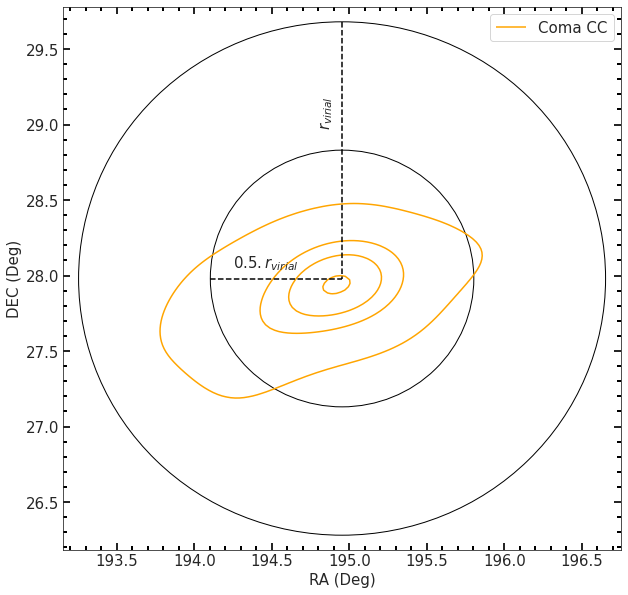

In [116]:
figure, ax = plt.subplots(figsize = (10,10))
cmap = ListedColormap(['red','blue'])
ax.scatter(tab_comb_g['RA_1'].value, tab_comb_g['Dec_1'].value, c =cl,
           s = pow(10,tab_comb_g['HI_Def']*4), cmap = cmap
           ,vmin = -0.5, vmax =1.5,zorder = 100, marker = r'$\bullet$')

x_min = 194.953054-1.8
x_max = 194.953054+1.8
y_min = 27.980694 - 1.8
y_max = 27.980694 + 1.8

temp = tab_comb_g[ (tab_comb_g['RA_1']>x_min) & (tab_comb_g['RA_1']<x_max)]

temp = temp[ (temp['Dec_1']>y_min) & (temp['Dec_1']<y_max)]
for  row in temp :
  x = row['RA_1'] + 0.01
  y = row['Dec_1'] +0.08
  text = row['mangaid']
  if text!= '1-404358':
    ax.annotate(text,(x,y), rotation = 20, zorder = 200)
  else:
    ax.annotate(text,(x,y-0.02), rotation = 0, zorder = 200)

ax.plot([194.953054- 1.7/2,194.953054], [27.980694,27.980694],'--',color = 'black', label = '_nolegend_')
ax.plot([194.953054,194.953054], [27.980694 +1.7 ,27.980694 ],'--',color = 'black', label = '_nolegend_')
sb.kdeplot(df_coma.RAJ2000.values, df_coma.DEJ2000.values, 
            color = 'orange', levels = [0.5, 0.8, 0.9,0.99, 1], label = 'Coma CC')
c = plt.Circle([194.953054, 27.980694], radius = 1.7/2,fill = False, color = 'black')
ax.add_artist(c)

c = plt.Circle([194.953054, 27.980694], radius = 1.7,fill = False, color = 'black')
ax.add_artist(c)

ax.annotate(r'$0.5.r_{virial}$',(194.25, 28.05))
ax.annotate(r'$r_{virial}$',(194.8, 29), rotation = 90)

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xlabel('RA (Deg)')
ax.set_ylabel('DEC (Deg)')
ax.legend()
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())


ax.tick_params(which='both', width=2,direction="in", top = True,right = True,
               bottom = True, left = True)
ax.tick_params(which='major', length=7,direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")


#plt.legend(['Quenched','Star-forming'])

[WARNING]: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation. (FutureWarning)
  warnings.warn(



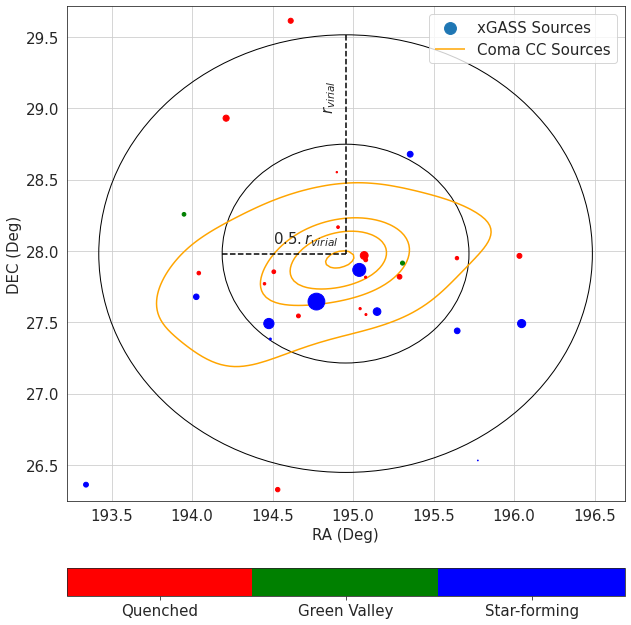

In [118]:
figure, ax = plt.subplots(figsize = (10,13))

vr = 92/60

cen_ra = 194.953054
cen_dec = 27.980694

x_min = cen_ra  - vr - 0.2
x_max = cen_ra  + vr + 0.2
y_min = cen_dec - vr - 0.2
y_max = cen_dec + vr + 0.2

temp = tab_rep[(tab_rep['RA_1']>x_min) & (tab_rep['RA_1']<x_max) ]
temp = temp[ (temp['Dec_1']>y_min) & (temp['Dec_1']<y_max)]
z = []

for i in temp['lgssfr'].value:
  if i<-11.8:
    z.append(0)
  elif i>=-11.8 and i< -10.8:
    z.append(1)
  elif i>=-10.8:
    z.append(2)

cmap = ListedColormap(['red','green','blue'])


img = ax.scatter(temp['RA_1'].value, temp['Dec_1'].value, c= z, cmap = cmap,
           s = pow(10,temp['HI_Def'].value*2.5)
           ,vmin = -0.5, vmax =2.5,zorder = 100, label = 'xGASS Sources')
cb = plt.colorbar(img,ax = [ax], location = 'bottom', anchor  = (0.5, 1.5))
cb.set_ticks([0,1,2])
cb.set_ticklabels(['Quenched', 'Green Valley', 'Star-forming'])
ax.plot([cen_ra- vr/2,cen_ra], [cen_dec,cen_dec],'--',color = 'black', label = '_nolegend_')
ax.plot([cen_ra,cen_ra], [cen_dec +vr ,cen_dec ],'--',color = 'black', label = '_nolegend_')
sb.kdeplot(df_coma.RAJ2000.values, df_coma.DEJ2000.values, color = 'orange'
           , levels = [0.5, 0.8, 0.9,0.99, 1], label = 'Coma CC Sources',)
c = plt.Circle([cen_ra, cen_dec ], radius = vr/2,fill = False, color = 'black')
ax.add_artist(c)

c = plt.Circle([cen_ra, cen_dec], radius = vr,fill = False, color = 'black')
ax.add_artist(c)

ax.annotate(r'$0.5.r_{virial}$',(194.5, 28.05))
ax.annotate(r'$r_{virial}$',(194.8, 29), rotation = 90)

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xlabel('RA (Deg)')
ax.set_ylabel('DEC (Deg)')
plt.grid()
ax.legend()


In [119]:
tab_rep_coma = tab_rep[ (tab_rep['RA_1']>x_min) & (tab_rep['RA_1']<x_max)]
tab_rep_coma  = tab_rep_coma[ (tab_rep_coma['Dec_1']>y_min) & (tab_rep_coma['Dec_1']<y_max)]

In [120]:
from astropy.coordinates import angular_separation

In [121]:
w = np.pi/180
dist = angular_separation(194.953054*w, 27.980694*w, temp['RA_1'].value*w, temp['Dec_1'].value*w)/w

Text(0, 0.5, '$DEF_{HI}$')

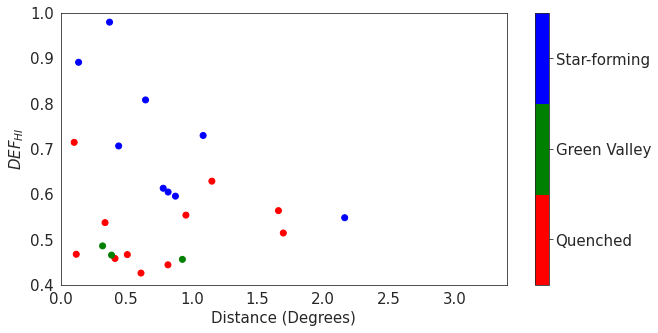

In [122]:
x = dist
y = temp['HI_Def']

plt.figure(figsize = (10,5))
cmap = colors.ListedColormap(['red','green','blue'])
img = plt.scatter(x,y, c =z , cmap = cmap,vmin = -0.5, vmax =2.5)
cb = plt.colorbar(img)
cb.set_ticks([0,1,2])
cb.set_ticklabels(['Quenched', 'Green Valley', 'Star-forming'])
plt.xlim(0,3.4)
plt.ylim(0.4,1)
plt.xlabel('Distance (Degrees)')
plt.ylabel(r'$DEF_{HI}$')

### **xCold GASS**

In [123]:
tab_CO = Table.read('data/xCOLD_xGASS.fits')
tab_CO.rename_column('SDSS_1','SDSS')
tab_M_CO = Table.read('data/xCOLD_GASS_MaNGA.fits')

m = []
for i in tab_M_CO['mangaid']:
  m.append(i.split()[0])
df_M_CO = tab_M_CO.to_pandas()
df_M_CO['mangaid'] = m

df_CO_HDSF= pd.merge(df_SF,df_M_CO, on = 'mangaid')
df_CO_HDQ  = pd.merge(df_noSF, df_M_CO, on = 'mangaid')

In [ ]:
df_SF.keys()

In [124]:
df_noSF[['mangaid','lgMHI','HIsrc']]

,mangaid,lgMHI,HIsrc
0,1-119212,9.375,4
11,1-623756,8.324,4
16,1-230042,9.470,4
30,1-591260,8.106,4
31,1-78688,7.979,4
55,1-115377,8.976,4
61,1-404358,8.357,4
62,1-457185,8.065,4
64,1-82382,9.386,3
78,1-335271,9.294,4


In [125]:
df_CO_M_DEF = pd.merge(df_HI_def, df_M_CO, on = 'mangaid')

In [126]:
tab_CO_GS = join(tab_rep, tab_CO, keys = 'SDSS')
tab_CO_GS_M = join(tab_rep, tab_CO, keys = 'SDSS')

[WARNING]: Cannot merge meta key 'DATE-HDU' types <class 'str'> and <class 'str'>, choosing DATE-HDU='2022-08-23T11:39:56' (MergeConflictWarning)
  warnings.warn(



[WARNING]: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation. (FutureWarning)
  warnings.warn(

[WARNING]: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation. (FutureWarning)
  warnings.warn(



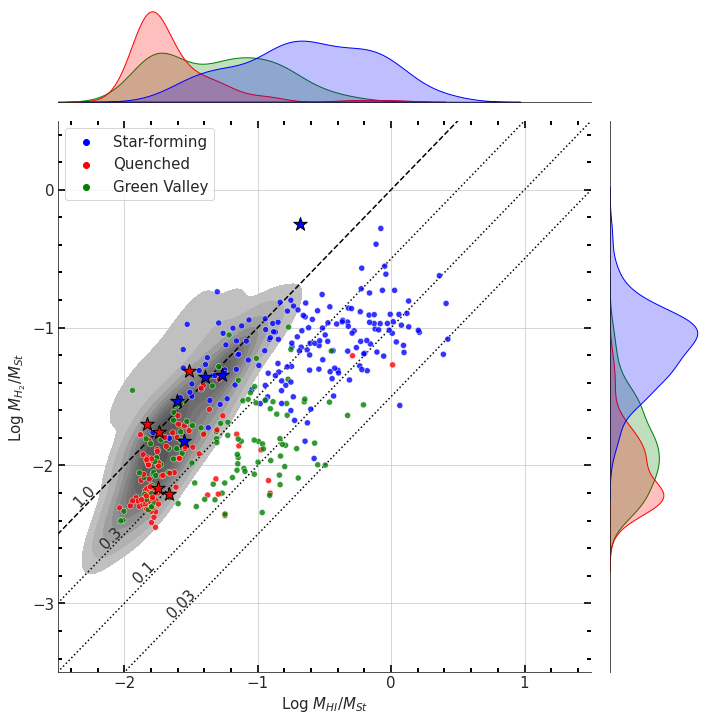

In [137]:
data = tab_CO_GS
x = data['lgMHI_1'].value.astype(float)
y = data['LOGMH2'] + data['LIM_LOGMH2']

x -= data['LOGMSTAR']
y -= data['LOGMSTAR']
y = y.value.astype(float)
z = []

for i in data['lgssfr']:
  if i<-11.8:
    z.append('Quenched')
  elif i>=-11.8 and i< -10.8:
    z.append('Green Valley')
  elif i>=-10.8:
    z.append('Star-forming')

data = data[data['HI_Def']>0.5]

cmap = ListedColormap(['red','green','blue']) #"scatter" | "kde" | "hist" | "hex" | "reg" | "resid
g = sb.jointplot(x,y,hue=z, vmin = -0.5, vmax = 2.5, kind = 'scatter' ,
             palette = {'Quenched' : 'red', 'Green Valley' : 'green', 
                        'Star-forming':'blue'},xlim = (-2.5,1.5), ylim = (-3.5,0.5),
                 height = 10, zorder = 110, alpha = 0.8)
g.set_axis_labels('Log $M_{HI}/M_{St}$', r'Log $M_{H_2}/M_{St}$')

x = data['lgMHI_1'].value.astype(float)
y = data['LOGMH2'] + data['LIM_LOGMH2']

x -= data['LOGMSTAR']
y -= data['LOGMSTAR']
y = y.value.astype(float)

sb.kdeplot(x,y, fill = True ,ax = g.ax_joint, color = 'grey')
x = np.linspace(-2.5,1.5)
y = 1*x
g.ax_joint.plot(x,y, '--',color  = 'black')

x = np.linspace(-2.5,1.5)
y = 1*x - 0.5
g.ax_joint.plot(x,y,':', color  = 'black' )

x = np.linspace(-2.5,1.5)
y = 1*x - 1
g.ax_joint.plot(x,y, ':',color  = 'black')

x = np.linspace(-2.5,1.5)
y = 1*x - 1.5
g.ax_joint.plot(x,y,':', color  = 'black')


g.ax_joint.xaxis.set_minor_locator(AutoMinorLocator())
g.ax_joint.yaxis.set_minor_locator(AutoMinorLocator())


g.ax_joint.tick_params(which='both', width=2,direction="in", top = True,right = True,
               bottom = True, left = True)
g.ax_joint.tick_params(which='major', length=7,direction="in")
g.ax_joint.tick_params(which='minor', length=4, color='black',direction="in")

g.ax_joint.set_yticks([-3,-2,-1,0])
g.ax_joint.set_xticks([-2,-1,0,1])
g.ax_joint.annotate('1.0',(-2.4,-2.3), rotation = 45)
g.ax_joint.annotate('0.3',(-2.2,-2.6), rotation = 45)
g.ax_joint.annotate('0.1',(-1.95,-2.85), rotation = 45)
g.ax_joint.annotate('0.03',(-1.7,-3.1), rotation = 45)


data = df_CO_HDSF
x = data['lgMHI'].values.astype(float)
y = data['LOGMH2'] + data['LIM_LOGMH2']

x -= data['LOGMSTAR']
y -= data['LOGMSTAR']
y = y.values.astype(float)

g.ax_joint.scatter(x,y, marker = '*', s= 200, color = 'blue', zorder = 200,
                    edgecolor='black', linewidth = 1)



data = df_CO_HDQ
x = data['lgMHI'].values.astype(float)
y = data['LOGMH2'] + data['LIM_LOGMH2']

x -= data['LOGMSTAR']
y -= data['LOGMSTAR']
y = y.values.astype(float)

g.ax_joint.scatter(x,y, marker = '*', s= 200, color = 'red', zorder = 200,
                   edgecolor='black', linewidth = 1)
g.ax_joint.grid()

[WARNING]: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation. (FutureWarning)
  warnings.warn(



Text(-1.7, -3.1, '0.03')

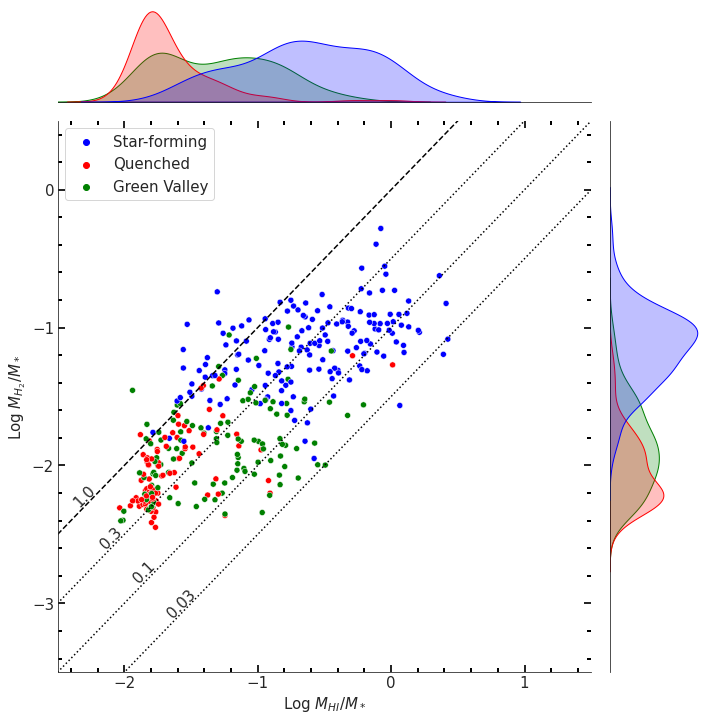

In [128]:
data = tab_CO_GS
x = data['lgMHI_1'].value.astype(float)
y = data['LOGMH2'] + data['LIM_LOGMH2']

x -= data['LOGMSTAR']
y -= data['LOGMSTAR']
y = y.value.astype(float)
z = []

for i in data['lgssfr']:
  if i<-11.8:
    z.append('Quenched')
  elif i>=-11.8 and i< -10.8:
    z.append('Green Valley')
  elif i>=-10.8:
    z.append('Star-forming')

s = []
for i in data['HI_Def']:
  if i>=0.5:
    s.append(1)
  else :
    s.append(0)
  

cmap = ListedColormap(['red','green','blue']) #"scatter" | "kde" | "hist" | "hex" | "reg" | "resid
g = sb.jointplot(x,y,hue=z, vmin = -0.5, vmax = 2.5, kind = 'scatter' ,
             palette = {'Quenched' : 'red', 'Green Valley' : 'green', 
                        'Star-forming':'blue'},xlim = (-2.5,1.5), ylim = (-3.5,0.5),
                 height = 10)
g.set_axis_labels('Log $M_{HI}/M_*$', r'Log $M_{H_2}/M_*$')
x = np.linspace(-2.5,1.5)
y = 1*x
g.ax_joint.plot(x,y, '--',color  = 'black')

x = np.linspace(-2.5,1.5)
y = 1*x - 0.5
g.ax_joint.plot(x,y,':', color  = 'black' )

x = np.linspace(-2.5,1.5)
y = 1*x - 1
g.ax_joint.plot(x,y, ':',color  = 'black')

x = np.linspace(-2.5,1.5)
y = 1*x - 1.5
g.ax_joint.plot(x,y,':', color  = 'black')


g.ax_joint.xaxis.set_minor_locator(AutoMinorLocator())
g.ax_joint.yaxis.set_minor_locator(AutoMinorLocator())


g.ax_joint.tick_params(which='both', width=2,direction="in", top = True,right = True,
               bottom = True, left = True)
g.ax_joint.tick_params(which='major', length=7,direction="in")
g.ax_joint.tick_params(which='minor', length=4, color='black',direction="in")

g.ax_joint.set_yticks([-3,-2,-1,0])
g.ax_joint.set_xticks([-2,-1,0,1])
g.ax_joint.annotate('1.0',(-2.4,-2.3), rotation = 45)
g.ax_joint.annotate('0.3',(-2.2,-2.6), rotation = 45)
g.ax_joint.annotate('0.1',(-1.95,-2.85), rotation = 45)
g.ax_joint.annotate('0.03',(-1.7,-3.1), rotation = 45)

<Figure size 432x432 with 0 Axes>

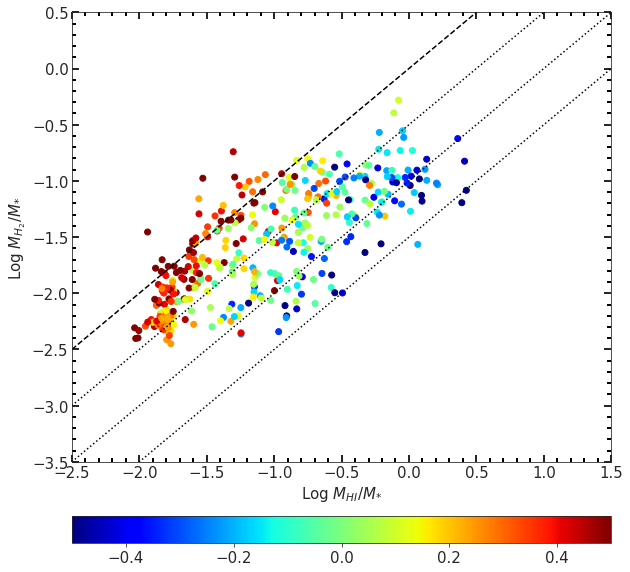

In [129]:
data = tab_CO_GS

x = data['lgMHI_1'].value.astype(float)
y = data['LOGMH2'] + data['LIM_LOGMH2']

x -= data['LOGMSTAR']
y -= data['LOGMSTAR']
y = y.value.astype(float)

s = []
for i in data['HI_Def']:
  if i>=0.5:
    s.append(1)
  else :
    s.append(0)
s  = np.array(s)

z = []
for i in data['lgssfr']:
  if i<-11.8:
    z.append(0)
  elif i>=-11.8 and i< -10.8:
    z.append(1)
  elif i>=-10.8:
    z.append(2)


fig = plt.figure(figsize=(6, 6))

gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
  
fig = plt.figure(figsize = (12,10))

ax = fig.add_subplot(gs[1,0])
img =  ax.scatter(x,y,c=data['HI_Def'], cmap = 'jet', vmin = -0.5, vmax= 0.5)
ax.set_xlabel(r'Log $M_{HI}/M_{*}$')
ax.set_ylabel(r'Log $ M_{H_2}/M_{*}$' )
cb = plt.colorbar(img, ax = [ax], location = 'bottom', anchor = (0.5,-2))

x = np.linspace(-2.5,1.5)
y = 1*x
ax.plot(x,y, '--',color  = 'black')

x = np.linspace(-2.5,1.5)
y = 1*x - 0.5
ax.plot(x,y,':', color  = 'black' )

x = np.linspace(-2.5,1.5)
y = 1*x - 1
ax.plot(x,y, ':',color  = 'black')

x = np.linspace(-2.5,1.5)
y = 1*x - 1.5
ax.plot(x,y,':', color  = 'black')

ax.set_xlim(-2.5,1.5) 
ax.set_ylim(-3.5,0.5)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())


ax.tick_params(which='both', width=2,direction="in", top = True,right = True,
               bottom = True, left = True)
ax.tick_params(which='major', length=7,direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")

plt.subplots_adjust(hspace = 0.1)

<Figure size 432x432 with 0 Axes>

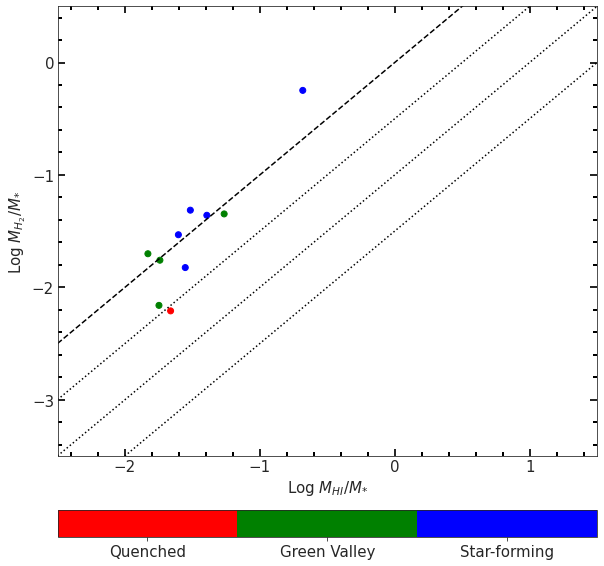

In [130]:
data = df_CO_M_DEF

x = data['lgMHI'].values.astype(float)
y = data['LOGMH2'] + data['LIM_LOGMH2']

x -= data['LOGMSTAR']
y -= data['LOGMSTAR']
y = y.values.astype(float)
z = []

s = []
for i in data['HI_Def']:
  if i>=0.5:
    s.append(1)
  else :
    s.append(0)

s  = np.array(s)

for i in data['lgssfr']:
  if i<-11.8:
    z.append(0)
  elif i>=-11.8 and i< -10.8:
    z.append(1)
  elif i>=-10.8:
    z.append(2)


fig = plt.figure(figsize=(6, 6))

gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
  
fig = plt.figure(figsize = (12,10))

ax = fig.add_subplot(gs[1,0])

cmap = ListedColormap(['red','green','blue']) #"scatter" | "kde" | "hist" | "hex" | "reg" | "resid
img =  ax.scatter(x,y,c=z, vmin = -0.5, vmax = 2.5,  cmap = cmap)
ax.set_xlabel(r'Log $M_{HI}/M_{*}$')
ax.set_ylabel(r'Log $ M_{H_2}/M_{*}$' )
cb = plt.colorbar(img, ax = [ax], location = 'bottom', anchor = (0.5,-2))
cb.set_ticks([0,1,2])
cb.set_ticklabels(['Quenched','Green Valley','Star-forming'])

x = np.linspace(-2.5,1.5)
y = 1*x
ax.plot(x,y, '--',color  = 'black')

x = np.linspace(-2.5,1.5)
y = 1*x - 0.5
ax.plot(x,y,':', color  = 'black' )

x = np.linspace(-2.5,1.5)
y = 1*x - 1
ax.plot(x,y, ':',color  = 'black')

x = np.linspace(-2.5,1.5)
y = 1*x - 1.5
ax.plot(x,y,':', color  = 'black')

ax.set_xlim(-2.5,1.5) 
ax.set_ylim(-3.5,0.5)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())


ax.tick_params(which='both', width=2,direction="in", top = True,right = True,
               bottom = True, left = True)
ax.tick_params(which='major', length=7,direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")

ax.set_yticks([-3,-2,-1,0])
ax.set_xticks([-2,-1,0,1])
plt.subplots_adjust(hspace = 0.05)

In [131]:
df_CO_HDSF[['mangaid', 'LOGMH2', 'LIM_LOGMH2']]

,mangaid,LOGMH2,LIM_LOGMH2
0,1-456772,8.870748,0.00000
1,1-116725,8.731519,0.00000
2,1-335441,9.036598,0.00000
3,1-117014,9.045714,0.00000
4,1-298482,0.000000,8.01954


In [132]:
df_CO_HDQ[['mangaid', 'lgMHI','LOGMH2']]

,mangaid,lgMHI,LOGMH2
0,1-384400,8.329,0.000000
1,1-115435,8.637,8.765565
2,1-115158,8.732,0.000000
3,1-456399,7.999,0.000000
4,1-42184,9.590,9.572013


Text(0, 0.5, 'log $M_{H2}/M_{HI} $')

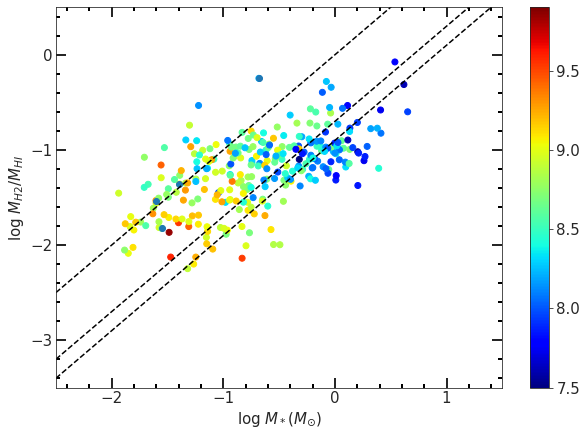

In [133]:
fig = plt.figure(figsize = (10,7))
ax  = fig.subplots()
x =  tab_CO['lgMHI'] - tab_CO['LOGMSTAR']
y = tab_CO['LOGMH2'] - tab_CO['LOGMSTAR']
img = ax.scatter(x,y, c = tab_CO['LOGMUST'], cmap = 'jet', vmin = 7.5, vmax = 9.9)
plt.colorbar(img, ax = ax)
x = df_CO_HDSF['lgMHI'] - df_CO_HDSF['LOGMSTAR']
y = df_CO_HDSF['LOGMH2'] - df_CO_HDSF['LOGMSTAR']
ax.scatter(x,y)


x= np.linspace(-2.5,1.5)
y=x

ax.plot(x,y,'--', color = 'black', label = '_nolegend_')

y = x-0.7
ax.plot(x,y,'--', color = 'black', label = '_nolegend_')

y = x-0.9
ax.plot(x,y,'--', color = 'black', label = '_nolegend_')


ax.set_xlim(-2.5,1.5)
ax.set_ylim(-3.5,0.5)

ax.set_xticks([-2,-1,0,1])
ax.set_yticks([-3,-2,-1,0])


ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', width=2,direction="in", top = True,
               right = True,bottom = True, left = True)
ax.tick_params(which='major', length=10,direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")
ax.set_xlabel(r'log $M_* (M_{\odot})$')
ax.set_ylabel(r'log $M_{H2}/M_{HI} $')

In [134]:
df_CO_HDSF

,plateifu_x,mangaid,RA_1,Dec_1,zSDSS,Dlum,lgMstar,petrR50_r,petrR90_r,petrR50_z,...,WCO21_FLAG,Z_CO21,FLAG_APEX,ICO_APEX,LCO_APEX,RMS_APEX,SN_APEX,WCO_APEX,ZCO_APEX,plateifu_y
0,8934-3701,1-456772,194.02542,27.678109,0.016483,71.500000,9.118738,3.23,7.81,3.32,...,0,0.00000,0,0.0,0.0,0.0,0.0,0.0,0.0,b'8934-3701 '
1,12083-12705,1-116725,344.36123,13.001654,0.025680,112.099998,10.556000,7.08,16.92,6.24,...,0,0.00000,0,0.0,0.0,0.0,0.0,0.0,0.0,b'12083-12705 '
2,11967-1901,1-335441,231.94761,9.624913,0.031190,136.800003,10.569000,3.07,9.55,2.85,...,0,0.03119,0,0.0,0.0,0.0,0.0,0.0,0.0,b'11967-1901 '
3,12085-6103,1-117014,345.92943,13.926541,0.027060,118.300003,10.405000,3.88,10.23,3.56,...,0,0.00000,0,0.0,0.0,0.0,0.0,0.0,0.0,b'12085-6103 '
4,9495-6101,1-298482,122.55074,22.772292,0.015594,67.599998,9.366620,4.73,10.14,4.62,...,0,0.00000,0,0.0,0.0,0.0,0.0,0.0,0.0,b'9495-6101 '


### **SDSS Spectra**

In [ ]:
df_spec = pd.read_csv('data/HI_Def_spec.csv')
df_spec = df_spec.rename(columns = {'name' : 'mangaid'})

In [ ]:
df_spec['spec_class'] = ['Broadline', 'Star-Forming', 'Star-Forming','Broadline','Broadline',
 'Star-Forming','Broadline', 'Broadline','Star-Forming', 'Starburst',
 'Star-Forming', 'Star-Forming', 'Broadline','        ','Broadline',
 'Broadline', 'Star-Forming', 'Broadline', 'Broadline', '         ',
 'Star-Forming',  'Broadline', '        ', '         ','AGN',
  'Broadline',  'AGN', '         ' ,  'Broadline','Star-Forming',
 'Broadline', '       ', 'Broadline', '   ']

In [ ]:
cl = []
for mangaid in df_spec.mangaid:
  if mangaid in df_SF.mangaid.values:
    cl.append(1)
  else:
    cl.append(0)

In [ ]:
def SNR_cut(df,col,value):
  SNR =  df[col]/np.sqrt(df[col + '_err'])
  return np.where(SNR>=value , df[col],np.nan)

In [ ]:
df_spec['MaNGA_class'] = cl

lines = ['nii_6584_flux','h_alpha_flux','h_beta_flux','oiii_5007_flux'
          ,'oi_6300_flux','sii_6717_flux','h_alpha_eqw']
em_ab = []
for i, row in df_spec.iterrows():
  if row['h_alpha_eqw']>0:
    em_ab.append('Emission')
  else:
    em_ab.append('Absorption')

for i in lines:
  df_spec[i] = np.abs(df_spec[i].values)
  if i!= 'h_alpha_eqw':
    df_spec[i] = SNR_cut(df_spec, i,3)
df_spec['f_type'] = em_ab

In [ ]:
fig, ax = plt.subplots()

x = np.log10(df_spec['nii_6584_flux'].values/df_spec['h_alpha_flux'].values)
y = np.log10(df_spec['h_alpha_eqw'].values)

cmap = colors.ListedColormap(['red','blue'])

img = ax.scatter(x,y, c= df_spec['MaNGA_class'], cmap = cmap, vmin = -0.5, vmax =1.5)
ax.set_xlim(-1,0.6)
ax.set_ylim(-0.5, 2)
cb = plt.colorbar(img, ax = ax, label = 'MaNGA Classification')
cb.set_ticks([0,1])
cb.set_ticklabels(['Quenched','Star-Forming'])

ax.plot([-1,0.6],[np.log10(3),np.log10(3)], '--', color = 'black')
ax.plot([-1,0.6],[np.log10(0.5),np.log10(0.5)], '--', color = 'black')
ax.plot([-1,0.6],[np.log10(0.5),np.log10(0.5)], '--', color = 'black')

ax.plot([-0.4,-0.4],[np.log10(3),2], '--', color = 'black')
ax.plot([-0.4,0.6],[np.log10(6),np.log10(6)], '--', color = 'black')
"""
psf = (logniiha < -0.4) & (ewha.value > 3)                        # Pure Star Forming
  sagn = (logniiha > -0.4) & (ewha.value > 6)                       # Strong AGN
  wagn = (logniiha > -0.4) & ((ewha.value > 3) & (ewha.value < 6))  # Weak AGN
  rg = ewha.value < 3                                               # Retired Galaxy  
  pg = (ewha.value < 0.5) & (ewnii.value < 0.5)                     # Passive Galaxy
"""

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', width=2,direction="in", top = True,right = True,
               left = True, bottom = True)
ax.tick_params(which='major', length=7,direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")
ax.set_title('WHAN Diagram using SDSS Spectra')
ax.set_xlabel( r'log [NII]/$H_{\alpha}$')
ax.set_ylabel(r'log $W_{H_{\alpha}}(\AA)$')

ax.annotate('SF',(-0.9,0.5))
ax.annotate('wAGN',(0.4,0.5))
ax.annotate('sAGN',(0.4,0.8))
ax.annotate('RG',(0.45,0))
ax.annotate('PG',(0.45,-0.4))

In [ ]:
whan_class = []
for i,row in df_spec.iterrows():
  x = np.log10(np.abs(row['nii_6584_flux']/row['h_alpha_flux']))
  y = np.log10(np.abs(row['h_alpha_eqw']))

  if y<= np.log10(0.5):
    whan_class.append('PG')
  elif y> np.log10(0.5) and y< np.log10(3):
    whan_class.append('RG')
  elif x<=-0.4:
    whan_class.append('SF')
  elif x>-0.4 and y<=np.log10(6):
    whan_class.append('wAGN')
  elif x>-0.4 and y>np.log10(6):
    whan_class.append('sAGN')
  
df_spec['WHAN_class'] = whan_class

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (20,10), sharey = True)
cmap = colors.ListedColormap(['red','blue'])

#BPT I

x = np.log10(df_spec['nii_6584_flux'].values/df_spec['h_alpha_flux'].values)
y = np.log10(df_spec['oiii_5007_flux'].values/df_spec['h_beta_flux'].values)

img = ax[0].scatter(x,y, c= df_spec['MaNGA_class'], cmap = cmap, vmin = -0.5, vmax =1.5)

bpt_class_I = []
for i,j in zip(x,y):
  if np.isnan(i)  or np.isnan(j):
    bpt_class_I.append('LowSNR')
  elif j< 0.61/(i-0.05)+1.3:
    bpt_class_I.append('SF')
  elif j >= 0.61/(i-0.05)+1.3 and j < 0.61/(i-0.47)+1.19 :
    bpt_class_I.append('Comp')
  elif j >= 0.61/(i-0.47)+1.19:
    bpt_class_I.append('AGN')

x = np.linspace(-1.3,-0.1)
y  = 0.61/(x-0.05)+1.3

ax[0].plot(x,y, '--',color = 'black')

x = np.linspace(-2, 0.3)
y  = 0.61/(x-0.47)+1.19

ax[0].plot(x,y, '-',color = 'red')

ax[0].set_xticks(np.arange(-2,0.55, 0.5))

ax[0].set_xlim(-2,1)
ax[0].set_ylim(-1.2, 1.5)

ax[0].annotate('HII',(-1,0))
ax[0].annotate('Comp',(-0.25,-0.5))
ax[0].annotate('AGN',(-0.25,1.25))

ax[0].set_xlabel( r'log [NII]/$H_{\alpha}$')
ax[0].set_ylabel(r'log OIII/$H_{\beta}$')


# BPT II 

x = np.log10(df_spec['sii_6717_flux'].values/df_spec['h_alpha_flux'].values)
y = np.log10(df_spec['oiii_5007_flux'].values/df_spec['h_beta_flux'].values)

img = ax[1].scatter(x,y, c= df_spec['MaNGA_class'], cmap = cmap, vmin = -0.5, vmax =1.5)


bpt_class_II = []
for i,j in zip(x,y):
  if np.isnan(i)  or np.isnan(j):
    bpt_class_II.append('LowSNR')
  elif j< 0.72/(i-0.32) + 1.3:
    bpt_class_II.append('SF')
  elif j >= 0.72/(i-0.32) + 1.3 and j < 1.89*i + 0.76 :
    bpt_class_II.append('LINER')
  elif j >= 0.72/(i-0.32) + 1.3 and j >= 1.89*i + 0.76:
    bpt_class_II.append('Seyfert')

x = np.linspace(-2, 0.3)
y  = 0.72/(x-0.32) + 1.3

ax[1].plot(x,y, '-',color = 'red')

x = np.linspace(-0.31, 0.8)
y  = 1.89*x + 0.76
ax[1].plot(x,y, '--',color = 'Black')

ax[1].set_xlim(-1.2,0.8)

ax[1].set_xticks(np.arange(-1,0.75,0.25))

ax[1].annotate('HII',(-1,0))
ax[1].annotate('LINER',(0.25,0))
ax[1].annotate('Seyfert',(-0.5,1.25))

ax[1].set_xlabel(r'log [SII]/$H_{\beta}$')

# BPT III

x = np.log10(df_spec['oi_6300_flux'].values/df_spec['h_alpha_flux'].values)
y = np.log10(df_spec['oiii_5007_flux'].values/df_spec['h_beta_flux'].values)

img = ax[2].scatter(x,y, c= df_spec['MaNGA_class'], cmap = cmap, vmin = -0.5, vmax =1.5)

bpt_class_III = []

for i,j in zip(x,y):
  if np.isnan(i)  or np.isnan(j):
    bpt_class_III.append('LowSNR')
  elif j< 0.73/(i-0.59) + 1.33:
    bpt_class_III.append('SF')
  elif j >= 0.73/(i-0.59) + 1.33 and j < 1.18*i + 1.30 :
    bpt_class_III.append('LINER')
  elif j >= 0.73/(i-0.59) + 1.33 and j >= 1.18*i + 1.30:
    bpt_class_III.append('Seyfert')


x = np.linspace(-2, 0.3)
y  = 0.73/(x-0.59) + 1.33
ax[2].plot(x,y, '-',color = 'red')
x = np.linspace(-0.52, 0.8)
y  = 1.18*x + 1.30
ax[2].plot(x,y, '--',color = 'Black')

ax[2].set_xlim(-1.2,0.8)

ax[2].set_xticks(np.arange(-1,0.75,0.25))

ax[2].annotate('HII',(-1,0))
ax[2].annotate('LINER',(0.25,0))
ax[2].annotate('Seyfert',(-0.5,1.25))

ax[2].set_xlabel(r'log [OI]/$H_{\beta}$')

for a in ax :

  a.xaxis.set_minor_locator(AutoMinorLocator())
  a.yaxis.set_minor_locator(AutoMinorLocator())

  a.tick_params(which='both', width=2,direction="in", top = True,right = True,
                left = True, bottom = True)
  a.tick_params(which='major', length=7,direction="in")
  a.tick_params(which='minor', length=4, color='black',direction="in")


cb = plt.colorbar(img, ax = ax, label = 'MaNGA Classification', anchor = (1.3,0))
cb.set_ticks([0,1])
cb.set_ticklabels(['Quenched','Star-Forming'])
fig.suptitle('BPT Diagram with SDSS Spectra | SNR > 3')
plt.subplots_adjust(wspace = 0)

In [ ]:
bpt_class = []
for i,j,k in zip(bpt_class_I, bpt_class_II, bpt_class_III):
  if i ==j == k=='SF':
    bpt_class.append('SF')
  elif i =='Comp' and j==k =='SF':
    bpt_class.append('Comp')
  elif (i=='AGN') and (j=='LINER'  or j=='Seyfert') and (k=='LINER'  or k=='Seyfert') :
    bpt_class.append('AGN')
  elif i=='AGN' and j==k=='Seyfert':
    bpt_class.append('Seyfert')
  elif i == 'LowSNR' or j == 'LowSNR' or 'LowSNR':
    bpt_class.append('Invalid')
  else:
   bpt_class.append('Ambiguous')

In [ ]:
df_spec['BPT_class'] = bpt_class

In [ ]:
df_spec_SF = df_spec[df_spec['MaNGA_class']==1]
df_spec_noSF = df_spec[df_spec['MaNGA_class']==0]

In [ ]:
df_spec_SF[['specObjID','mangaid','spec_class','WHAN_class','BPT_class']]

In [ ]:
len(df_spec_noSF)

## **LSB**

In [ ]:
!wget https://data.sdss.org/sas/dr17/manga/photo/pymorph/1.1.1/manga-pymorph-DR17.fits

In [ ]:
def filter_LSB(tab, hdul):

  tab['R_s']        = tab['A_HL_SE_DISK']/( 1.9992*tab['N_SE_DISK'] - 0.3271)
  tab['mu_disk_0']  = tab['M_SE_DISK'] + 2.5*np.log10(2*np.pi*tab['R_s']**2) 
  tab['mu_disk_c0'] = tab['mu_disk_0'] +2.5*np.log10(tab['BA_SE_DISK']) -  10*np.log10(1 + tab['Z'])
  tab_LSB           = tab[tab['mu_disk_c0']>=21]

  tab_LSB_r = tab_LSB[['MANGA_ID'      ,'PLATEIFU'   ,'OBJID','RA','DEC'          
                     ,'Z','FLAG_FAILED_S',
         'FLAG_FAILED_SE','FLAG_FIT'   ,'M_SE_BULGE','A_HL_SE_BULGE','N_SE_BULGE',
         'BA_SE_BULGE'   ,'PA_SE_BULGE','M_SE_DISK' ,'A_HL_SE_DISK' , 'R_s',
         'N_SE_DISK'     , 'BA_SE_DISK','PA_SE_DISK', 
         'mu_disk_c0']].to_pandas()

  tab_g        = Table.read(hdul[1])
  tab_g['R_s'] = tab_g['A_HL_SE_DISK']/( 1.9992*tab_g['N_SE_DISK'] - 0.3271)
  tab_g['mu_disk_0'] = tab_g['M_SE_DISK'] + 2.5*np.log10(2*np.pi*tab_g['R_s']**2)
  tab_g['mu_disk_c0']  = tab_g['mu_disk_0'] +2.5*np.log10(tab_g['BA_SE_DISK']) -  10*np.log10(1 + tab_g['Z'])

  tab_g = tab_g[['MANGA_ID'      ,'PLATEIFU'   ,'OBJID','RA','DEC'          ,'Z','FLAG_FAILED_S',
          'FLAG_FAILED_SE','FLAG_FIT'   ,'M_SE_BULGE','A_HL_SE_BULGE','N_SE_BULGE',
          'BA_SE_BULGE'   ,'PA_SE_BULGE','M_SE_DISK' ,'A_HL_SE_DISK' , 'R_s',
          'N_SE_DISK'     , 'BA_SE_DISK','PA_SE_DISK', 
          'mu_disk_c0']].to_pandas()

  tab_LSB_g = tab_LSB_r[0:0]
  for i in tab_LSB_r['MANGA_ID']:
    if i in tab_LSB_r['MANGA_ID'].values:
      tab_LSB_g = tab_LSB_g.append(tab_g[tab_g['MANGA_ID']==i])

  tab_i        = Table.read(hdul[3])
  tab_i['R_s'] = tab_i['A_HL_SE_DISK']/( 1.9992*tab_i['N_SE_DISK'] - 0.3271)
  tab_i['mu_disk_0'] = tab_i['M_SE_DISK'] + 2.5*np.log10(2*np.pi*tab_i['R_s']**2)
  tab_i['mu_disk_c0']  = tab_i['mu_disk_0'] +2.5*np.log10(tab_i['BA_SE_DISK']) -  10*np.log10(1 + tab_i['Z'])

  tab_i = tab_i[['MANGA_ID'      ,'PLATEIFU'   ,'OBJID','RA','DEC'          ,'Z','FLAG_FAILED_S',
          'FLAG_FAILED_SE','FLAG_FIT'   ,'M_SE_BULGE','A_HL_SE_BULGE','N_SE_BULGE',
          'BA_SE_BULGE'   ,'PA_SE_BULGE','M_SE_DISK' ,'A_HL_SE_DISK' , 'R_s',
          'N_SE_DISK'     , 'BA_SE_DISK','PA_SE_DISK', 
          'mu_disk_c0']].to_pandas()

  tab_LSB_i = tab_LSB_r[0:0]
  for i in tab_LSB_r['MANGA_ID']:
    if i in tab_LSB_r['MANGA_ID'].values:
      tab_LSB_i = tab_LSB_i.append(tab_g[tab_g['MANGA_ID']==i])
  return tab_LSB_g, tab_LSB_r, tab_LSB_i

In [ ]:
hdul = fits.open('manga-pymorph-DR17.fits')
tab    = Table.read(hdul[2])
tab_pym    = Table.read(hdul[2])

### **Sersic + Exp**

#### **$R_S<R_{SE}$**

In [ ]:
tab_SE = tab[tab['A_HL_SE_BULGE']<tab['A_HL_SE_DISK']]
tab_SE = tab_SE[tab_SE['FLAG_FIT']==2]

LSB_g1, LSB_r1, LSB_i1 = filter_LSB(tab_SE,hdul) 

In [ ]:
len(LSB_r1)

#### **$R_S>R_{SE}$**

In [ ]:
tab_SE = tab[tab['A_HL_SE_BULGE']>tab['A_HL_SE_DISK']]
tab_SE = tab_SE[tab_SE['FLAG_FIT']==2]
tab_SE['N_SE_DISK'] = tab_SE['N_SE_BULGE']
tab_SE['A_HL_SE_DISK'] = tab_SE['A_HL_SE_BULGE']
tab_SE['M_SE_DISK'] = tab_SE['M_SE_BULGE']
tab_SE['BA_SE_DISK'] = tab_SE['BA_SE_BULGE']

LSB_g2, LSB_r2, LSB_i2 = filter_LSB(tab_SE,hdul) 

In [ ]:
len(LSB_r2)

### **Sersic**

In [ ]:
tab_SE = tab[tab['A_HL_SE_BULGE']<tab['A_HL_SE_DISK']]
tab_SE = tab_SE[tab_SE['FLAG_FIT']==1]
tab_SE = tab_SE[tab_SE['FLAG_FIT']==1]

tab_SE['N_SE_DISK']    = tab_SE['N_S']
tab_SE['A_HL_SE_DISK'] = tab_SE['A_HL_S']
tab_SE['M_SE_DISK']    = tab_SE['M_S']
tab_SE['BA_SE_DISK']   = tab_SE['BA_S']

LSB_g3, LSB_r3, LSB_i3 = filter_LSB(tab_SE,hdul) 
len(LSB_r3)

In [ ]:
len(LSB_r1) + len(LSB_r2) + len(LSB_r3)

In [ ]:
LSB_r1.to_csv('LSB_r_SE_sersicbulge.csv')
LSB_r2.to_csv('LSB_r_SE_expbulge.csv')

LSB_r3.to_csv('LSB_r_S.csv')

In [ ]:
for i in df_HI_def.mangaid:
  if i in LSB_r1.MANGA_ID.values:
    print(i)
  if i in LSB_r2.MANGA_ID.values:
    print(i)
  if i in LSB_r3.MANGA_ID.values:
    print(i)

# **Saving to Google Drive**

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

In [ ]:
cd '/content/gdrive/MyDrive/Star forming Bars in S0 Galaxies/DR17/S0/SFB'

In [ ]:
ls

Choose a location in your drive

In [ ]:
cd '/content/gdrive/MyDrive/'

In [ ]:
ids = [i[:-9] for i in os.listdir()]
ids

# **Maps with Mapplot**

In [ ]:
download = 0
format   = 'png'

for plateifu in df_SF.plateifu:
 
  if not os.path.exists(f'{plateifu}'):
      os.mkdir(f'{plateifu}')

  maps = Maps(plateifu=plateifu,mode='remote')
  mangaid = maps.mangaid

  # Set the size of image cutout 
  scale = maps.wcs.to_header()['PC2_2']*3600
  size = 2*maps.wcs.to_header()['CRPIX1']*scale

  # Get SDSS Image
  optical=maps.getImage()
  scale_s = optical.wcs.to_header()['PC2_2']*3600
  size_s  = 2*optical.wcs.to_header()['CRPIX1']*scale_s

  # Physical Scale
  c          = 299792  # speed of light [km/s]
  H0         = 70  # [km s^-1 Mpc^-1]
  redshift   = maps.dapall['z']
  D          = c * redshift / H0  # approx. distance to galaxy [Mpc]
  dist_scale = 1 / 206265 * D * 1e3  # kpc per arc_secs
  d          = size_s*dist_scale
  r          = d/2  #kpc.
  
  # Optical Image
  fig = plt.figure(figsize = (10,10))
  ax1 = fig.add_subplot()
  ax1.grid(False)
  ax1.imshow(optical.data, extent = (-r,r,-r,r))
  ax1.grid(False)

  if download:
      fig.savefig(f'{plateifu}/SDSS_cutout',bbox_inches = 'tight',format=format)
  
  #------------------------------------------------------------------------------------------

  # Get DeCALS Image
  scale_s = optical.wcs.to_header()['PC2_2']*3600
  size_s  = 2*optical.wcs.to_header()['CRPIX1']*scale_s
  img = Cutout_L(ra = optical.ra, dec = optical.dec, width = size_s, height=size_s, scale = size_s/512 )

  fig = plt.figure(figsize = (10,10))
  ax1 = fig.add_subplot()
  ax1.grid(False)
  ax1.imshow(img.image, extent = (-r,r,-r,r))
  ax1.grid(False)
  #ax1.annotate(f'manga {plateifu}',(512-512/3,512-512/20),weight='bold',family='serif',color = 'white')
  if download:
      fig.savefig(f'{plateifu}/legacy_cutout',bbox_inches = 'tight',format=format)

    # Crop Image to match IFU size

  optical.get_new_cutout(size,size,size/512)
  filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
  levels=[60.,  90., 120., 150., 180., 210., 240.]

# H-alpha with optical contours

  fig = plt.figure(figsize = (10,10))
  ax3 = fig.add_subplot( )
  ha = maps.emline_gflux_ha_6564

  d = size*dist_scale
  r = d/2

  ax3.grid(False)
  cbr = mapplot.plot(dapmap=ha,return_cbrange=True)
  img = ax3.imshow(goodspax(ha),vmin=cbr[0],vmax=cbr[1],cmap='jet', extent = (-r,r,-r,r), origin = 'lower')
  ax3.grid(False)
  #ax3.set_autoscale_on(False)
  #ax3.contour(filter_r, transform=ax3.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
  #ax3.annotate(r'H alpha Map',(len(ha)-len(ha)/3.5,len(ha)-len(ha)/13),weight='bold',family='serif')
  cb=plt.colorbar(img,ax=ax3,anchor=(0,5),shrink=0.824)
  cb.set_label(r'$1\times10^{-17}ergcm^{-2}s^{-1}$')

  if download:
      fig.savefig(f'{plateifu}/H_alpha',bbox_inches = 'tight',format = format)
  #------------------------------------------------------------------------------------------

  # H-delta with optical contours

  fig = plt.figure(figsize = (10,10))
  ax3 = fig.add_subplot( projection=maps.wcs,slices=('x','y',0))
  ha = maps.emline_gflux_hdel_4102

  ax3.grid(False)
  cbr = mapplot.plot(dapmap=ha,return_cbrange=True)
  img = ax3.imshow(goodspax(ha),vmin=cbr[0],vmax=cbr[1],cmap='jet')
  ax3.grid(False)
  ax3.set_autoscale_on(False)
  ax3.contour(filter_r, transform=ax3.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
  #ax3.annotate(r'H delta Map',(len(ha)-len(ha)/3.5,len(ha)-len(ha)/13),weight='bold',family='serif')
  cb=plt.colorbar(img,ax=ax3,anchor=(0,5),shrink=0.824)
  cb.set_label(r'$1\times10^{-17}ergcm^{-2}s^{-1}$')
  ax3.set_xlabel('pos.eq.ra')
  ax3.set_ylabel('pos.eq.dec')
  ax3.axis('off')

  if download:
      fig.savefig(f'{plateifu}/H_delta',bbox_inches = 'tight',format = format)
  #------------------------------------------------------------------------------------------

  # WHAN Map

  # grab the NII/Ha flux ratio, Ha and NII equivalent width arrays
  nii=maps.emli40ne_gflux_nii_6585
  ha=maps.emline_gflux_ha_6564
  niiha = nii/ha
  ewha = maps['emline_sew_ha_6564']
  ewnii = maps['emline_sew_nii_6585']
  # take the log of the NII/Ha ratio
  logniiha = np.log10(niiha.value)

  # create the WHAN categories
  psf  = (logniiha < -0.4)  & (ewha.value > 3)
  sagn = (logniiha > -0.4)  & (ewha.value > 6)
  wagn = (logniiha > -0.4)  & ((ewha.value > 3) & (ewha.value < 6))
  rg   = ewha.value < 3
  pg   = (ewha.value < 0.5) & (ewnii.value < 0.5) 

  # create a custom array for a WHAN categories (we copy the EW Ha array just to get a 2d-array of the original size)
  value = ewha.value.copy()
  value[psf]  = 1     # pure star-forming 
  value[sagn] = 2     # strong agn
  value[wagn] = 3     # weak agn
  value[rg]   = 4     # retired galaxies
  value[pg]   = 5     # passive galaxies

  # Set ivar to 0 where the SNR < 1
  niiha_low_snr = mapplot.mask_low_snr(niiha.value, niiha.ivar, snr_min=1)
  ewha_low_snr = mapplot.mask_low_snr(ewha.value, ewha.ivar, snr_min=1)
  ewnii_low_snr = mapplot.mask_low_snr(ewnii.value, ewnii.ivar, snr_min=1)
  low_snr = np.logical_or(niiha_low_snr, ewha_low_snr, ewnii_low_snr)

  ivar = ewha.value.copy()
  ivar[low_snr] = 0
  value[low_snr] = np.nan

  # Set the size of image cutout 
  scale = maps.wcs.to_header()['PC2_2']*3600
  size = 2*maps.wcs.to_header()['CRPIX1']*scale

  # WHAN IFU
  fig = plt.figure(figsize = (10,10))
  ax2 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))
  ax2.grid(False)
  cmap = colors.ListedColormap(['red', 'blue', 'goldenrod', 'green', 'purple'])
  nocov = ewha.pixmask.get_mask('NOCOV',dtype=np.bool)
  mask = np.where(nocov==True,np.nan,1)
  #fig, ax2, cb = mapplot.plot(value=value, ivar=ivar, mask=nocov, cmap=cmap,fig=fig,ax=ax2, use_masks='NOCOV', return_cb=True, cbrange=(0.5, 5.5), title='')
  img = ax2.imshow(value,cmap=cmap,vmin=0.5,vmax=5.5)
  ax2.grid(False)
  ax2.set_autoscale_on(False)
  #ax2.annotate(r'WHAN Map',(len(ha)-len(ha)/4,len(ha)-len(ha)/13),weight='bold',family='serif')

  filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
  levels=[60.,  90., 120., 150., 180., 210., 240.]
  ax2.contour(filter_r, transform=ax2.get_transform(optical.wcs), colors='black',levels=levels,zorder=11)

  cb=plt.colorbar(img,ax=ax2,anchor=(0,5),shrink=0.824)
  cb.set_ticks([1, 2, 3, 4, 5])
  cb.set_ticklabels(['PSF', 'SAGN', 'WAGN', 'RG', 'PG'])
  ax2.set_xlabel('pos.eq.ra')
  ax2.set_ylabel('pos.eq.dec')
  ax2.axis('off')
  if download:
      fig.savefig(f'{plateifu}/WHAN',bbox_inches = 'tight',format=format)
  #------------------------------------------------------------------------------------------
  
  fig = plt.figure(figsize = (10,10))
  ax4 = fig.add_subplot()
  m, f ,a = maps.get_bpt(show_plot=False)
  
  SF = sf= m['sf']['global'].astype('float64')*5
  COMP = m['comp']['global'].astype('float64')*4
  LIN = m['liner']['global'].astype('float64')*3
  SEY = m['seyfert']['global'].astype('float64')*2
  AMB = m['ambiguous']['global'].astype('float64')*1
  
  bpt = SF + COMP + LIN + SEY + AMB
  
  cmap = colors.ListedColormap(['grey','red', 'purple', 'green', 'cyan'])
  nocov = ewha.pixmask.get_mask('NOCOV')
  
  bpt[bpt==0]=np.nan
  
  #fig, ax4, cb = mapplot.plot(value=bpt, ivar = bpt, mask=nocov, cmap=cmap,fig=fig,ax=ax4, use_masks='NOCOV', return_cb=True, cbrange=(0.5, 5.5), title='')
  img = ax4.imshow(bpt,cmap=cmap,vmin=0.5,vmax=5.5,extent = (-r,r,-r,r), origin = 'lower')
  #ax4.set_autoscale_on(False)
  #ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs), colors='black',levels=levels,zorder=11)

  cb=plt.colorbar(img,ax=ax4,anchor=(0,5),shrink=0.824)
  cb.set_ticks([1, 2, 3, 4, 5])
  cb.set_ticklabels(['Ambiguous','Seyfert','LINER','Comp', 'SF'])

  #ax4.annotate(r'BPT Map',(len(ha)-len(ha)/4.6,len(ha)-len(ha)/12),weight='bold',family='serif')

  if download:
      fig.savefig(f'{plateifu}/BPT',bbox_inches = 'tight', format = format)
  
  #------------------------------------------------------------------------------------------

  dn=maps.specindex_dn4000

  fig = plt.figure(figsize = (10,10))
  ax4 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))
  ax4.grid(False)
  cbr=mapplot.plot(dapmap=dn,return_cbrange=True)
  img = ax4.imshow(goodspax(dn),vmin=cbr[0],vmax=cbr[1],cmap='jet')
  ax4.grid(False)
  ax4.set_autoscale_on(False)
  ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
  cb=plt.colorbar(img,ax=ax4,anchor=(0,5),shrink=0.824)
  ax4.set_xlabel('pos.eq.ra')
  ax4.set_ylabel('pos.eq.dec')
  #ax4.annotate(r'Dn 4000 Map',(len(ha)-len(ha)/3.3,len(ha)-len(ha)/13),weight='bold',family='serif')

  ax4.axis('off')
  if download:
      fig.savefig(f'{plateifu}/DN4000',bbox_inches = 'tight',format = format)
      
  #------------------------------------------------------------------------------------------
  fig = plt.figure(figsize = (10,10))
  ax3 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))
  nii = maps.emline_gflux_nii_6585
  n2 = nii/ ha
  logn2 = np.log10(n2)
  logoh = 8.90 + 0.57 * logn2

  mask_bad_data = n2.pixmask.get_mask(['NOCOV', 'UNRELIABLE', 'DONOTUSE'])
  min_snr = 3.
  mask_nii_low_snr = (np.abs(nii.value * np.sqrt(nii.ivar)) < min_snr)
  mask_ha_low_snr = (np.abs(ha.value * np.sqrt(ha.ivar)) < min_snr)

  mask =  (mask_bad_data | mask_nii_low_snr | mask_ha_low_snr).astype(np.bool)
  ax3.grid(False)
  cbr = mapplot.plot(dapmap=logoh,mask=mask,return_cbrange=True)
  mask = np.where(mask==True,np.nan,1)
  img = ax3.imshow(logoh.value*mask,vmin=cbr[0],vmax=cbr[1],cmap = 'viridis')
  ax3.grid(False)
  ax3.set_autoscale_on(False)
  ax3.contour(filter_r, transform=ax3.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
  cb=plt.colorbar(img,ax=ax3,anchor=(0,5),shrink=0.824,label= '12+log(O/H)')
  ax3.set_xlabel('pos.eq.ra')
  ax3.set_ylabel('pos.eq.dec')
  #ax3.annotate(r'N2 Metallicity Map',(len(ha)-len(ha)/2.5,len(ha)-len(ha)/13),weight='bold',family='serif')
  ax3.axis('off')
  if download:
      fig.savefig(f'{plateifu}/Metallicity',bbox_inches = 'tight',format = format)
      
  #------------------------------------------------------------------------------------------
  
  hb = maps.emline_gflux_hb_4862
  ha_hb = maps.getMapRatio('emline_gflux','ha_6564','hb_4862')
  ha_sf    = ha*sf
  hb_sf    = hb*sf
  ha_hb_sf = ha_hb*sf
  
  z = maps.dapall['z']

  fa = ha_sf*1e-17*pow(10,2.468*0.934*np.log10(ha_hb_sf.value/2.86))
  D_L = cosmo.luminosity_distance(z).to(u.cm)
  Lha =  (fa.value*4*np.pi*D_L*D_L)*(u.erg/u.second)
  SFR = 5.5e-42*Lha
  SFR = SFR.value*(u.solMass/u.year)
  cube = maps.getCube()

  M    = cube.vacs.firefly['mastar']

  M = cube.vacs.firefly['mastar']._make_map('stellar_mass')
  M = 10**np.where(M>-10,M,0)
  
  sSFR = np.log10(SFR.value/M)

  fig = plt.figure(figsize = (10,10))
  ax4 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))
  ax4.grid(False)

  ax4.imshow(sSFR, cmap = 'jet')
  ax4.grid(False)
  ax4.set_autoscale_on(False)
  ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
  if download:
    fig.savefig(f'{plateifu}/sSFR',bbox_inches = 'tight',format = format)

  ang_dist = Planck15.kpc_proper_per_arcmin(z).to(u.kpc/u.arcsec)
  area = (ang_dist.value**2*maps.bin_area.value)
  area = area*(u.kpc**2)
  SFRD = SFR/area

  R   = maps.spx_ellcoo_elliptical_radius.value
  R_e = float(maps.header['reff'])

  x = (R/R_e)
  y = SFRD
  
  fig = plt.figure(figsize = (10,10))
  ax = fig.add_subplot()
  ax.scatter(x,y)
  ax.set_xlabel(r'$R/R_e$')
  ax.set_ylabel('SFRD ' + r'$M_{\odot}kpc^{-2}yr^{-1}$')
  
  ax.xaxis.set_minor_locator(AutoMinorLocator())
  ax.yaxis.set_minor_locator(AutoMinorLocator())

  ax.tick_params(which='both', width=2,direction="in")
  ax.tick_params(which='major', length=7,direction="in")
  ax.tick_params(which='minor', length=4, color='black',direction="in")
  
  if download:
      fig.savefig(f'{plateifu}/SFRD',bbox_inches = 'tight',format = format)
  
  #------------------------------------------------------------------------------------------  
  
  # OIII/OII map
  OIII_OII= maps.getMapRatio('emline_gflux','oiii_5008','oii_3729')

  fig = plt.figure(figsize = (10,10))   
  ax4 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))
  ax4.grid(False)
  cbr = mapplot.plot(dapmap = OIII_OII, return_cbrange = True)
  
  img = ax4.imshow(goodspax(OIII_OII),vmin=cbr[0],vmax=cbr[1],cmap = 'magma')
  ax4.grid(False)
  ax4.set_autoscale_on(False)
  ax4.contour(filter_r, transform = ax4.get_transform(optical.wcs), colors = 'red',levels = levels,zorder=11)
  cb=plt.colorbar(img, ax=ax4,anchor=(0,5),shrink=0.824)
  ax4.set_xlabel('pos.eq.ra')
  ax4.set_ylabel('pos.eq.dec')
  #ax4.annotate(r'OIII/OII Map',(len(ha)-len(ha)/3.3,len(ha)-len(ha)/13),weight='bold',family='serif')
  ax4.axis('off')
  if download:
      fig.savefig(f'{plateifu}/OIII_OII',bbox_inches = 'tight',format = format)

  #------------------------------------------------------------------------------------------
      
    # H alpha EW
  ewha = maps['emline_sew_ha_6564']
  fig = plt.figure(figsize = (10,10))
  ax2 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))

  ax2.grid(False)
  cbr=mapplot.plot(dapmap=ewha,return_cbrange=True)
  img = ax2.imshow(goodspax(ewha),vmin=cbr[0],vmax=cbr[1],cmap = 'plasma')
  ax2.grid(False)
  ax2.set_autoscale_on(False)
  ax2.contour(filter_r, transform=ax2.get_transform(optical.wcs), colors='white',levels=levels,zorder=11)
  cb=plt.colorbar(img,ax=ax2,anchor=(0,5),shrink=0.824)
  ax2.set_xlabel('pos.eq.ra')
  ax2.set_ylabel('pos.eq.dec')
  #ax2.annotate(r'H alpha EW Map',(len(ha)-len(ha)/2.7,len(ha)-len(ha)/13),weight='bold',family='serif')
  cb.set_label(r'$\AA$')
  ax2.axis('off')
  if download:
      fig.savefig(f'{plateifu}/ewH_alpha',bbox_inches = 'tight')
  
  #--------------------------------------------------------------------------------------------
    # H delta EW
  ewha = maps.emline_sew_hdel_4102
  fig = plt.figure(figsize = (10,10))
  ax2 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))

  ax2.grid(False)
  cbr=mapplot.plot(dapmap=ewha,return_cbrange=True)
  img = ax2.imshow(goodspax(ewha),vmin=cbr[0],vmax=cbr[1],cmap = 'plasma')
  ax2.grid(False)
  ax2.set_autoscale_on(False)
  ax2.contour(filter_r, transform=ax2.get_transform(optical.wcs), colors='white',levels=levels,zorder=11)
  cb=plt.colorbar(img,ax=ax2,anchor=(0,5),shrink=0.824)
  ax2.set_xlabel('pos.eq.ra')
  ax2.set_ylabel('pos.eq.dec')
  #ax2.annotate(r'H delta EW Map',(len(ha)-len(ha)/2.7,len(ha)-len(ha)/13),weight='bold',family='serif')
  cb.set_label(r'$\AA$')

  ax2.axis('off')
  if download:
      fig.savefig(f'{plateifu}/ewH_delta',bbox_inches = 'tight')
      
  # OIII 5007 EW
  ewOIII = maps['emline_sew_oiii_5008']
  fig = plt.figure(figsize = (10,10))
  ax3 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))

  ax3.grid(False)
  cbr = mapplot.plot(dapmap = ewOIII ,return_cbrange = True)
  img = ax3.imshow(goodspax(ewOIII),vmin=cbr[0],vmax=cbr[1],cmap = 'plasma')
  ax3.grid(False)
  ax3.set_autoscale_on(False)
  ax3.contour(filter_r, transform = ax3.get_transform(optical.wcs), colors = 'white',levels = levels,zorder=11)
  cb=plt.colorbar(img,ax=ax3,anchor=(0,5),shrink=0.824)
  ax3.set_xlabel('pos.eq.ra')
  ax3.set_ylabel('pos.eq.dec')
  ax3.annotate(r'OIII EW Map',(len(ha)-len(ha)/3.3,len(ha)-len(ha)/13),weight='bold',family='serif')
  cb.set_label(r'$\AA$')

  ax3.axis('off')
  if download:
      fig.savefig(f'{plateifu}/ewOIII',bbox_inches = 'tight',format = format)
    #------------------------------------------------------------------------------------------
  break

In [ ]:
r

In [ ]:
# Set the size of image cutout 
scale = maps.wcs.to_header()['PC2_2']*3600
size = 2*maps.wcs.to_header()['CRPIX1']*scale

# Get SDSS Image
optical=maps.getImage()
scale_s = optical.wcs.to_header()['PC2_2']*3600
size_s  = 2*optical.wcs.to_header()['CRPIX1']*scale_s

# GalFIT apertures
with open(f'/content/Kugelblitz/data/{plateifu}.json', 'r') as fout:
  m = json.load(fout)

mods = m[0]

# Physical Scale
c          = 299792  # speed of light [km/s]
H0         = 70  # [km s^-1 Mpc^-1]
redshift   = maps.dapall['z']
D          = c * redshift / H0  # approx. distance to galaxy [Mpc]
dist_scale = 1 / 206265 * D * 1e3  # kpc per arc_secs
d          = size_s*dist_scale
r          = d/2  #kpc.

# Optical Image
fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot()
ax1.grid(False)
ax1.imshow(optical.data, extent = (-r,r,-r,r))
ax1.grid(False)

apertures = aperture_gen(mods[:-1],dist_scale,r, 
                        origin = 'center', a_offset = 45)

for k, aperture in enumerate(apertures):
  apertures[aperture].plot(ax1,color = colors_[k], label = models[k])
ax1.legend()
ax1.set_xlabel('kpc')
ax1.set_ylabel('kpc')

In [ ]:
download = 0
format   = 'png'
for plateifu in dr16:

  if not os.path.exists(f'{plateifu}'):
      os.mkdir(f'{plateifu}')

  maps = Maps(plateifu=plateifu,mode='remote')
  mangaid = maps.mangaid

  # Set the size of image cutout 
  scale = maps.wcs.to_header()['PC2_2']*3600
  size = 2*maps.wcs.to_header()['CRPIX1']*scale

  # Get SDSS Image
  optical=maps.getImage()

  # Crop Image to match IFU size

  optical.get_new_cutout(size,size,size/512)
  filter_r = np.rot90(np.array(optical.data)[:,:,0].T )
  levels   = [60.,  90., 120., 150., 180., 210., 240.]
  ha       = maps.emline_gflux_ha_6564
  hb       = maps.emline_gflux_hb_4862
  ha_hb    = maps.getMapRatio('emline_gflux','ha_6564','hb_4862')

  m, f ,a  = maps.get_bpt(show_plot=False)
  
  sf       = m['sf']['global'].astype('float64')
  ha_sf    = ha*sf
  hb_sf    = hb*sf
  ha_hb_sf = ha_hb*sf
  
  z = maps.dapall['z']

  fa   = ha_sf*1e-17*pow(10,2.468*0.934*np.log10(ha_hb_sf.value/2.86))
  D_L  = cosmo.luminosity_distance(z).to(u.cm)
  Lha  =  (fa.value*4*np.pi*D_L*D_L)*(u.erg/u.second)
  SFR  = 5.5e-42*Lha
  SFR  = SFR.value*(u.solMass/u.year)
  cube = maps.getCube()

  M    = cube.vacs.firefly['mastar']

  M = cube.vacs.firefly['mastar']._make_map('stellar_mass')
  M = 10**np.where(M>-10,M,0)
  
  sSFR = np.log10(SFR.value/M)

  fig = plt.figure(figsize = (10,10))
  ax4 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))
  ax4.grid(False)

  img = ax4.imshow(sSFR, cmap = 'jet')
  ax4.grid(False)
  ax4.set_autoscale_on(False)
  ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
  cb = plt.colorbar(img, ax = ax4, shrink = 0.8)
  cb.set_label(r'$Log_{10}(1/yr)$')

  ax4.annotate(r'sSFR Map',(len(ha)-len(ha)/3.3,len(ha)-len(ha)/13),weight='bold',family='serif')
  if download:
    fig.savefig(f'{plateifu}/sSFR',bbox_inches = 'tight',format = format)

In [ ]:
cube.vacs.firefly['mastar'].data

In [ ]:
fig  = plt.figure(figsize = (33,60))
spec = gridspec.GridSpec(ncols=4, nrows=8, width_ratios=[1,1, 1.32,1.24], wspace=0.01,hspace=0.01)
for i,fil in enumerate(os.listdir()):
  
  img = plt.imread(f'{fil}/legacy_cutout')
  ax = fig.add_subplot(spec[i,0])
  ax.imshow(img)
  ax.axis('off')

  img = plt.imread(f'{fil}/SDSS_cutout')
  ax = fig.add_subplot(spec[i,1])
  ax.imshow(img)
  ax.axis('off')

  img = plt.imread(f'{fil}/BPT')
  ax = fig.add_subplot(spec[i,2])
  ax.imshow(img)
  ax.axis('off')

  img = plt.imread(f'{fil}/H_alpha')
  ax = fig.add_subplot(spec[i,3])
  ax.imshow(img)
  ax.axis('off')

In [ ]:
fig  = plt.figure(figsize = (35,60))
spec = gridspec.GridSpec(ncols=4, nrows=8, width_ratios=[1,1.001, 0.97,1.], wspace=0.01,hspace=0.01)
for i,fil in enumerate(os.listdir()[3:-1]):
  
  img = plt.imread(f'{fil}/ewH_alpha.png')
  ax = fig.add_subplot(spec[i,0])
  ax.imshow(img)
  ax.axis('off')

  img = plt.imread(f'{fil}/H_delta')
  ax = fig.add_subplot(spec[i,1])
  ax.imshow(img)
  ax.axis('off')

  img = plt.imread(f'{fil}/DN4000')
  ax = fig.add_subplot(spec[i,2])
  ax.imshow(img)
  ax.axis('off')

  img = plt.imread(f'{fil}/Metallicity')
  ax = fig.add_subplot(spec[i,3])
  ax.imshow(img)
  ax.axis('off')

# **Maps with Matplotlib**

## **Utils**

In [157]:
use_masks = ['NOCOV','LOWCOV','DEADFIBER','FORESTAR','NOVALUE','UNRELIABLE','MATHERROR','FITFAILED','NOCORRECTION','MULTICOMP','NEARBOUND','DONOTUSE']
def goodspax(dapmap,type=None, SNR = 1.0):
  if type==None:
    bad_data = dapmap.pixmask.get_mask(use_masks,dtype = np.bool)
    low_snr = abs(dapmap.value*np.sqrt(dapmap.ivar)) < SNR
    mask = np.logical_or.reduce((bad_data, low_snr))
    mask = np.where(mask==True,np.nan,1)

  elif type=='vel':

    low_snr = dapmap.snr<SNR
    bad_data = dapmap.pixmask.get_mask(use_masks,dtype = np.bool)
    mask = np.logical_or.reduce((bad_data, low_snr))
    mask = np.where(mask==True,1e-32,1)
   
  return dapmap.value*mask

In [158]:
def aperture_gen(models,angle_scale,len_scale, origin = 'center' , a_offset = 0):
  apertures = {}
  for i,model in enumerate(models):

    X_c = model[f'{i+1}_XC'].split('+')[0]
    if '*' in X_c:
      print('Error in X_c')
      X_c = float(X_c[1:-2])
    else:
      X_c = float(X_c)
    if origin == 'center':
      X_c-=64
    X_c*=(len_scale/128)

    Y_c = model[f'{i+1}_YC'].split('+')[0]
    if '*' in Y_c:
      print('Error in Y_c')
      Y_c = float(Y_c[1:-2])
    else:
      Y_c = float(Y_c)

    if origin == 'center':
      Y_c-=64
    Y_c*=(len_scale/128)

    PA = model[f'{i+1}_PA'].split('+')[0]
    if '*' in PA:
      print('Error in PA')
      PA = float(PA[1:-2])
    else:
      PA = float(PA)

    AR = model[f'{i+1}_AR'].split('+')[0]
    if '*' in AR:
      print('Error in AR')
      AR = float(AR[1:-2])
    else:
      AR = float(AR)


    keys = [i.split('_')[-1] for i in model.keys()]
    if'RE' in keys:
      RE = model[f'{i+1}_RE'].split('+')[0]
      if '*' in RE:
        print('Error in X_c')
        RE = float(RE[1:-2])
      else:
        RE = float(RE)

    else:
      RE = model[f'{i+1}_RS'].split('+')[0]
      if '*' in RE:
        print('Error in RS')
        RE = float(RE[1:-2])
      else:
        RE = float(RE)
        
    RE*=(0.394) # RE in arcseconds
    RE*angle_scale
    a = 2*RE
    b = AR*a
    print(a)
    aperture = aper.EllipticalAperture((X_c,Y_c), a,b,
                                       theta = np.pi/2 +(PA + a_offset)*np.pi/180)
    apertures[f'aper_{i+1}'] = aperture
  return apertures

In [159]:
def get_whan(maps):

  nii=maps.emli40ne_gflux_nii_6585
  ha =maps.emline_gflux_ha_6564
  niiha = nii/ha
  ewha = maps['emline_sew_ha_6564']
  ewnii = maps['emline_sew_nii_6585']
  # take the log of the NII/Ha ratio
  logniiha = np.log10(niiha.value)

  # create the WHAN categories
  psf  = (logniiha < -0.4)  & (ewha.value > 3)
  sagn = (logniiha > -0.4)  & (ewha.value > 6)
  wagn = (logniiha > -0.4)  & ((ewha.value > 3) & (ewha.value < 6))
  rg   = ewha.value < 3
  pg   = (ewha.value < 0.5) & (ewnii.value < 0.5) 

  # create a custom array for a WHAN categories (we copy the EW Ha array just to get a 2d-array of the original size)
  value = ewha.value.copy()
  value[psf]  = 1     # pure star-forming 
  value[sagn] = 2     # strong agn
  value[wagn] = 3     # weak agn
  value[rg]   = 4     # retired galaxies
  value[pg]   = 5     # passive galaxies

  # Set ivar to 0 where the SNR < 1
  niiha_low_snr = mapplot.mask_low_snr(niiha.value, niiha.ivar, snr_min=1)
  ewha_low_snr = mapplot.mask_low_snr(ewha.value, ewha.ivar, snr_min=1)
  ewnii_low_snr = mapplot.mask_low_snr(ewnii.value, ewnii.ivar, snr_min=1)
  low_snr = np.logical_or(niiha_low_snr, ewha_low_snr, ewnii_low_snr)

  ivar = ewha.value.copy()
  ivar[low_snr] = 0
  value[low_snr] = np.nan

  return value

## **Maps 2.0**

In [ ]:
for plateifu in SFB.plateifu:
  maps = Maps(plateifu=plateifu,mode='remote')
  mangaid = maps.mangaid

  gs = gridspec.GridSpec(ncols=4, nrows=2, width_ratios = [0.8,1,1,1], wspace=0.15,hspace=0.2)

  # Set the size of image cutout 
  scale = maps.wcs.to_header()['PC2_2']*3600
  size = 2*maps.wcs.to_header()['CRPIX1']*scale

  # SDSS Image
  optical = maps.getImage()
  scale_s = optical.wcs.to_header()['PC2_2']*3600
  size_s  = 2*optical.wcs.to_header()['CRPIX1']*scale_s
  fig     = plt.figure(figsize = (39,15))
  ax1     = fig.add_subplot(gs[0,0], projection = optical.wcs)
  ax1.imshow(optical.data)
  ax1.set_title('SDSS')

  optical.get_new_cutout(size,size,size/512)
  filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
  levels=[60.,  90., 120., 150., 180., 210., 240.]

  # Decals Image
  scale_s = optical.wcs.to_header()['PC2_2']*3600
  size_s  = 2*optical.wcs.to_header()['CRPIX1']*scale_s
  img     = Cutout_L(ra = optical.ra, dec = optical.dec,
                 width = size_s, height=size_s, scale = size_s/512 )

  ax2     = fig.add_subplot(gs[1,0], projection = img.wcs)
  ax2.imshow(img.image)
  optical.overlay_hexagon(ax2, transform = ax2.get_transform(optical.wcs), linewidth = 3)
  ax2.set_title('DeCALS')

  # H-alpha Map
  ha  = maps.emline_gflux_ha_6564
  ax1 = fig.add_subplot(gs[0,1], projection = maps.wcs, slices = ['x','y',0])
  cbr = mapplot.plot(dapmap=ha,return_cbrange=True)
  img = ax1.imshow(goodspax(ha),cmap='jet', vmin  = cbr[0], vmax = cbr[1])
  
  cb  = plt.colorbar(img, ax = ax1)
  cb.set_label(r'$1 \times 10^{-17} erg.s^{-1}.spaxel^{-1}.cm^{-2}$', size = 10)

  ax1.grid(False)
  ax1.set_autoscale_on(False)
  ax1.contour(filter_r, transform=ax1.get_transform(optical.wcs), colors='black',
              levels=levels,zorder=11)
  ax1.grid(False)
  ax1.set_title("Emission line Gaussian flux: H-alpha 6564")

  # WHAN
  nii   = maps.emli40ne_gflux_nii_6585
  ha    = maps.emline_gflux_ha_6564
  niiha = nii/ha
  ewha  = maps['emline_sew_ha_6564']
  ewnii = maps['emline_sew_nii_6585']

  # Take the log of the NII/Ha ratio
  logniiha = np.log10(niiha.value)

  # Create the WHAN categories
  psf  = (logniiha < -0.4)  & (ewha.value > 3)
  sagn = (logniiha > -0.4)  & (ewha.value > 6)
  wagn = (logniiha > -0.4)  & ((ewha.value > 3) & (ewha.value < 6))
  rg   = ewha.value < 3
  pg   = (ewha.value < 0.5) & (ewnii.value < 0.5) 

  # Create a custom array for a WHAN categories (we copy the EW Ha array just to get a 2d-array of the original size)
  value       = ewha.value.copy()
  value[psf]  = 1     # pure star-forming 
  value[sagn] = 2     # strong agn
  value[wagn] = 3     # weak agn
  value[rg]   = 4     # retired galaxies
  value[pg]   = 5     # passive galaxies

  # Set ivar to 0 where the SNR < 1
  niiha_low_snr = mapplot.mask_low_snr(niiha.value, niiha.ivar, snr_min=1)
  ewha_low_snr  = mapplot.mask_low_snr(ewha.value, ewha.ivar, snr_min=1)
  ewnii_low_snr = mapplot.mask_low_snr(ewnii.value, ewnii.ivar, snr_min=1)
  low_snr       = np.logical_or(niiha_low_snr, ewha_low_snr, ewnii_low_snr)

  ivar          = ewha.value.copy()
  ivar[low_snr] = 0
  value[low_snr]= np.nan

  # Set the size of image cutout 
  scale = maps.wcs.to_header()['PC2_2']*3600
  size  = 2*maps.wcs.to_header()['CRPIX1']*scale

  # WHAN IFU
  ax2   = fig.add_subplot(gs[0,2], projection=maps.wcs,slices=('x','y',0))
  cmap  = colors.ListedColormap(['red', 'blue', 'goldenrod', 'green', 'purple'])
  nocov = ewha.pixmask.get_mask('NOCOV',dtype=np.bool)
  mask  = np.where(nocov==True,np.nan,1)
  
  img = ax2.imshow(value,cmap=cmap,vmin=0.5,vmax=5.5)
  ax2.grid(False)
  ax2.set_autoscale_on(False)
  ax2.contour(filter_r, transform=ax2.get_transform(optical.wcs), colors='black',
              levels=levels,zorder=11)
  cb=plt.colorbar(img,ax=ax2,anchor=(0,5),shrink=0.824)
  cb.set_ticks([1, 2, 3, 4, 5])
  cb.set_ticklabels(['PSF', 'SAGN', 'WAGN', 'RG', 'PG'])
  ax2.set_xlabel('pos.eq.ra')
  ax2.set_ylabel('pos.eq.dec')
  ax2.grid(False)
  ax2.set_title('WHAN')

  # Metallicity

  ax3   = fig.add_subplot(gs[1,1], projection=maps.wcs,slices=('x','y',0))
  n2    = nii/ ha
  logn2 = np.log10(n2)
  logoh = 8.90 + 0.57 * logn2

  mask_bad_data = n2.pixmask.get_mask(['NOCOV', 'UNRELIABLE', 'DONOTUSE'])
  min_snr = 3.
  mask_nii_low_snr = (np.abs(nii.value * np.sqrt(nii.ivar)) < min_snr)
  mask_ha_low_snr = (np.abs(ha.value * np.sqrt(ha.ivar)) < min_snr)

  mask =  (mask_bad_data | mask_nii_low_snr | mask_ha_low_snr).astype(np.bool)
  ax3.grid(False)
  cbr  = mapplot.plot(dapmap=logoh,mask=mask,return_cbrange=True)
  mask = np.where(mask==True,np.nan,1)
  img  = ax3.imshow(logoh.value*mask,vmin=cbr[0],vmax=cbr[1],cmap = 'viridis')
  ax3.grid(False)
  ax3.set_autoscale_on(False)
  ax3.contour(filter_r, transform=ax3.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
  cb=plt.colorbar(img,ax=ax3,anchor=(0,5),shrink=0.824,label= '12+log(O/H)')
  ax3.set_xlabel('pos.eq.ra')
  ax3.set_ylabel('pos.eq.dec')
  ax3.set_title('Gas Phase Metallicity')

  ax4 = fig.add_subplot(gs[1,2],projection=maps.wcs,slices=('x','y',0))
  m, f ,a = maps.get_bpt(show_plot=False)
  
  SF   = m['sf']['global'].astype('float64')*5
  COMP = m['comp']['global'].astype('float64')*4
  LIN  = m['liner']['global'].astype('float64')*3
  SEY  = m['seyfert']['global'].astype('float64')*2
  AMB  = m['ambiguous']['global'].astype('float64')*1
  
  bpt  = SF + COMP + LIN + SEY + AMB
  
  cmap = colors.ListedColormap(['grey','red', 'purple', 'green', 'cyan'])
  
  bpt[bpt==0]=np.nan
  img = ax4.imshow(bpt,cmap=cmap,vmin=0.5,vmax=5.5)
  ax4.set_autoscale_on(False)
  ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs), colors='black',levels=levels,zorder=11)
  
  cb=plt.colorbar(img,ax=ax4)
  cb.set_ticks([1, 2, 3, 4, 5])
  cb.set_ticklabels(['Ambiguous','Seyfert','LINER','Comp', 'SF'])
  ax4.set_title('BPT')

  fig.savefig(f'{plateifu}.png', bbox_inches='tight')

In [ ]:

fig = plt.figure(figsize = (30,80))
gs  = gridspec.GridSpec(ncols=1, nrows=8,)

for i, mangaid in enumerate(ids_[16:]):

  maps = Maps(mangaid= str(mangaid),mode='remote')
  plateifu = maps.plateifu

  # Set the size of image cutout 
  scale = maps.wcs.to_header()['PC2_2']*3600
  size = 2*maps.wcs.to_header()['CRPIX1']*scale

  # Get SDSS Image
  optical=maps.getImage()

  # Crop Image to match IFU size

  optical.get_new_cutout(size,size,size/512)
  filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
  levels=[60.,  90., 120., 150., 180., 210., 240.]
  ax1 = fig.add_subplot(gs[i],projection=optical.wcs)
  scale_s = optical.wcs.to_header()['PC2_2']*3600
  size_s  = 2*optical.wcs.to_header()['CRPIX1']*scale_s
  img = Cutout_L(ra = optical.ra, dec = optical.dec, width = size_s, height=size_s, scale = size_s/512 )

  ax1 = fig.add_subplot(gs[i], projection=optical.wcs)
  ax1.grid(False)
  ax1.imshow(img.image)
  ax1.grid(False)
  title = ax1.set_title(f'{mangaid}', rotation = 90,weight='bold',family='serif'
  ,color = 'black', fontsize = 30)

  title.set_position((-0.03,0.4))
  ax1.axis('off')
plt.subplots_adjust(hspace = 0.01)

In [ ]:
fig = plt.figure(figsize = (30,80))
gs  = gridspec.GridSpec(ncols=1, nrows=8,)
for i, mangaid in enumerate(ids_[:8]):

  maps = Maps(mangaid=mangaid,mode='remote')
  mangaid = maps.plateifu

  # Set the size of image cutout 
  scale = maps.wcs.to_header()['PC2_2']*3600
  size = 2*maps.wcs.to_header()['CRPIX1']*scale

  # Get SDSS Image
  optical=maps.getImage()

  # Crop Image to match IFU size

  optical.get_new_cutout(size,size,size/512)
  filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
  levels=[60.,  90., 120., 150., 180., 210., 240.]
  ax1 = fig.add_subplot(gs[i],projection=optical.wcs)
  ax1.grid(False)
  ax1.imshow(optical.data)
  ax1.grid(False)
  optical.overlay_hexagon(ax1)
  ax1.axis('off')
plt.subplots_adjust(hspace = 0.01)

In [ ]:
import astropy.units as u

In [ ]:
fig = plt.figure(figsize = (30,80))
gs  = gridspec.GridSpec(ncols=1, nrows=8,)
ax_l = []
for i, mangaid in enumerate(ids_[:8]):

  maps = Maps(mangaid=mangaid,mode='remote')
  mangaid = maps.plateifu

  # Set the size of image cutout 
  scale = maps.wcs.to_header()['PC2_2']*3600
  size = 2*maps.wcs.to_header()['CRPIX1']*scale

  # Get SDSS Image
  optical=maps.getImage()

  # Crop Image to match IFU size

  optical.get_new_cutout(size,size,size/512)
  filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
  levels=[60.,  90., 120., 150., 180., 210., 240.]
  ax = fig.add_subplot(gs[i], projection=maps.wcs,slices=('x','y',0))
  ha = maps.emline_gflux_ha_6564

  ax.grid(False)
  cbr = mapplot.plot(dapmap=np.log10(ha),return_cbrange=True)
  img = ax.imshow(np.log10(goodspax(ha)),cmap='jet')
  ax.grid(False)
  ax.set_autoscale_on(False)
  ax.contour(filter_r, transform=ax.get_transform(optical.wcs), colors='black',levels=levels,zorder=11) 

  ax.coords[0].set_ticks([]*u.degree)
  ax.coords[1].set_ticks([]*u.degree)
  ax_l.append(ax)

cb=plt.colorbar(img,ax=ax_l,location = 'top', shrink=0.321, anchor = (0.5,1.07))
cb.set_label(r'$Log 1\times10^{-17}ergcm^{-2}s^{-1}$')
plt.subplots_adjust(hspace = 0.01)


In [ ]:
fig = plt.figure(figsize = (30,80))
gs  = gridspec.GridSpec(ncols=1, nrows=8,)
ax_l = []
for i, mangaid in enumerate(ids_[16:]):

  maps = Maps(mangaid=mangaid,mode='remote')
  mangaid = maps.plateifu

  # Set the size of image cutout 
  scale = maps.wcs.to_header()['PC2_2']*3600
  size = 2*maps.wcs.to_header()['CRPIX1']*scale

  # Get SDSS Image
  optical=maps.getImage()

  # Crop Image to match IFU size

  optical.get_new_cutout(size,size,size/512)
  filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
  levels=[60.,  90., 120., 150., 180., 210., 240.]
  ax4 = fig.add_subplot(gs[i],projection=maps.wcs,slices=('x','y',0))
  m, f ,a = maps.get_bpt(show_plot=False)
  
  SF = sf= m['sf']['global'].astype('float64')*5
  COMP = m['comp']['global'].astype('float64')*4
  LIN = m['liner']['global'].astype('float64')*3
  SEY = m['seyfert']['global'].astype('float64')*2
  AMB = m['ambiguous']['global'].astype('float64')*1
  
  bpt = SF + COMP + LIN + SEY + AMB
  
  cmap = colors.ListedColormap(['grey','red', 'purple', 'green', 'cyan'])
  
  bpt[bpt==0]=np.nan
  img = ax4.imshow(bpt,cmap=cmap,vmin=0.5,vmax=5.5)
  ax4.set_autoscale_on(False)
  ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs), colors='black',levels=levels,zorder=11)
  ax4.coords[0].set_ticks([]*u.degree)
  ax4.coords[1].set_ticks([]*u.degree)
  ax_l.append(ax4)
  
cb=plt.colorbar(img,ax=ax_l,location = 'top', shrink=0.321, anchor = (0.5,1.05))
cb.set_ticks([1, 2, 3, 4, 5])
cb.set_ticklabels(['Ambiguous','Seyfert','LINER','Comp', 'SF'])
plt.subplots_adjust(hspace = 0.01)


In [ ]:
fig = plt.figure(figsize = (30,80))
gs  = gridspec.GridSpec(ncols=1, nrows=8,)
ax_l = []
for i, mangaid in enumerate(ids_[8:16]):

  maps = Maps(mangaid=mangaid,mode='remote')
  mangaid = maps.plateifu

  # Set the size of image cutout 
  scale = maps.wcs.to_header()['PC2_2']*3600
  size = 2*maps.wcs.to_header()['CRPIX1']*scale

  # Get SDSS Image
  optical=maps.getImage()

  # Crop Image to match IFU size

  optical.get_new_cutout(size,size,size/512)
  filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
  levels=[60.,  90., 120., 150., 180., 210., 240.]
  ax4 = fig.add_subplot(gs[i],projection=maps.wcs,slices=('x','y',0))
# WHAN Map

  # grab the NII/Ha flux ratio, Ha and NII equivalent width arrays
  nii=maps.emli40ne_gflux_nii_6585
  ha =maps.emline_gflux_ha_6564
  niiha = nii/ha
  ewha = maps['emline_sew_ha_6564']
  ewnii = maps['emline_sew_nii_6585']
  # take the log of the NII/Ha ratio
  logniiha = np.log10(niiha.value)

  # create the WHAN categories
  psf  = (logniiha < -0.4)  & (ewha.value > 3)
  sagn = (logniiha > -0.4)  & (ewha.value > 6)
  wagn = (logniiha > -0.4)  & ((ewha.value > 3) & (ewha.value < 6))
  rg   = ewha.value < 3
  pg   = (ewha.value < 0.5) & (ewnii.value < 0.5) 

  # create a custom array for a WHAN categories (we copy the EW Ha array just to get a 2d-array of the original size)
  value = ewha.value.copy()
  value[psf]  = 1     # pure star-forming 
  value[sagn] = 2     # strong agn
  value[wagn] = 3     # weak agn
  value[rg]   = 4     # retired galaxies
  value[pg]   = 5     # passive galaxies

  # Set ivar to 0 where the SNR < 1
  niiha_low_snr = mapplot.mask_low_snr(niiha.value, niiha.ivar, snr_min=1)
  ewha_low_snr = mapplot.mask_low_snr(ewha.value, ewha.ivar, snr_min=1)
  ewnii_low_snr = mapplot.mask_low_snr(ewnii.value, ewnii.ivar, snr_min=1)
  low_snr = np.logical_or(niiha_low_snr, ewha_low_snr, ewnii_low_snr)

  ivar = ewha.value.copy()
  ivar[low_snr] = 0
  value[low_snr] = np.nan

  # Set the size of image cutout 
  scale = maps.wcs.to_header()['PC2_2']*3600
  size = 2*maps.wcs.to_header()['CRPIX1']*scale

  # WHAN IFU
  cmap = colors.ListedColormap(['red', 'blue', 'goldenrod', 'green', 'purple'])
  nocov = ewha.pixmask.get_mask('NOCOV',dtype=np.bool)
  mask = np.where(nocov==True,np.nan,1)
  img = ax4.imshow(value,cmap=cmap,vmin=0.5,vmax=5.5)
  ax4.set_autoscale_on(False)
  ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs), colors='black',levels=levels,zorder=11)
  ax4.coords[0].set_ticks([]*u.degree)
  ax4.coords[1].set_ticks([]*u.degree)

  ax_l.append(ax4)
  
cb=plt.colorbar(img,ax=ax_l,location = 'top', shrink=0.321, anchor = (0.5,1.05))
cb.set_ticks([1, 2, 3, 4, 5])
cb.set_ticklabels(['PSF', 'SAGN', 'WAGN', 'RG', 'PG'])
plt.subplots_adjust(hspace = 0.01)


In [ ]:
fig = plt.figure(figsize = (30,80))
gs  = gridspec.GridSpec(ncols=1, nrows=8)
ax_l =[]
for i,mangaid in enumerate(ids_[16:]):
  maps = Maps(mangaid=mangaid,mode='remote')
  plateifu = maps.plateifu

  # Set the size of image cutout 
  scale = maps.wcs.to_header()['PC2_2']*3600
  size = 2*maps.wcs.to_header()['CRPIX1']*scale

  # Get SDSS Image
  optical=maps.getImage()

  # Crop Image to match IFU size

  optical.get_new_cutout(size,size,size/512)
  filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
  levels=[60.,  90., 120., 150., 180., 210., 240.]
  ewha = maps['emline_sew_ha_6564']

  ax2 = fig.add_subplot(gs[i],projection=maps.wcs,slices=('x','y',0))

  ax2.grid(False)
  img = ax2.imshow((goodspax(ewha)),cmap = 'jet', vmin = 0)
  ax2.grid(False)
  ax2.set_autoscale_on(False)
  ax2.contour(filter_r, transform=ax2.get_transform(optical.wcs), colors='black',levels=levels,zorder=11)
  ax2.coords[0].set_ticks([]*u.degree)
  ax2.coords[1].set_ticks([]*u.degree)
  ax_l.append(ax2)
cb=plt.colorbar(img,ax=ax_l,location = 'top', shrink=0.321, anchor = (0.5,1.05))
cb.set_label(r'$\AA$')
plt.subplots_adjust(hspace = 0.01)

In [ ]:
fig = plt.figure(figsize = (30,80))
gs  = gridspec.GridSpec(ncols=1, nrows=8)
ax_l =[]
for i,mangaid in enumerate(ids[:5]):
  maps = Maps(mangaid=mangaid,mode='remote')
  plateifu = maps.plateifu

  # Set the size of image cutout 
  scale = maps.wcs.to_header()['PC2_2']*3600
  size = 2*maps.wcs.to_header()['CRPIX1']*scale

  # Get SDSS Image
  optical=maps.getImage()

  # Crop Image to match IFU size

  optical.get_new_cutout(size,size,size/512)
  filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
  levels=[60.,  90., 120., 150., 180., 210., 240.]
  ax3 = fig.add_subplot(gs[i], projection=maps.wcs,slices=('x','y',0))
  hd = maps.emline_gflux_hdel_4102

  ax3.grid(False)
  img = ax3.imshow(np.log10(goodspax(hd)),cmap='plasma')
  ax3.grid(False)
  ax3.set_autoscale_on(False)
  ax3.contour(filter_r, transform=ax3.get_transform(optical.wcs), colors='black',levels=levels,zorder=11)

  ax3.coords[0].set_ticks([]*u.degree)
  ax3.coords[1].set_ticks([]*u.degree)
  ax_l.append(ax3)


cb=plt.colorbar(img,ax=ax_l,location = 'top', shrink=0.321, anchor = (0.5,1.07))

cb.set_label(r'$Log_{10}(1\times10^{-17}ergcm^{-2}s^{-1})$')
plt.subplots_adjust(hspace = 0.01)


In [ ]:
fig = plt.figure(figsize = (30,220))
gs  = gridspec.GridSpec(ncols=1, nrows=22)
ax_l =[]
t = []
for i,mangaid in enumerate(ids_):

  maps = Maps(mangaid=mangaid,mode='remote')
  plateifu = maps.plateifu

  # Set the size of image cutout 
  scale = maps.wcs.to_header()['PC2_2']*3600
  size = 2*maps.wcs.to_header()['CRPIX1']*scale

  # Get SDSS Image
  optical=maps.getImage()

  # Crop Image to match IFU size

  optical.get_new_cutout(size,size,size/512)
  filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
  levels=[60.,  90., 120., 150., 180., 210., 240.]
  ax4 = fig.add_subplot(gs[i], projection=maps.wcs,slices=('x','y',0))
  dn=maps.specindex_dn4000

  m, f ,a  = maps.get_bpt(show_plot=False)
  sf       = m['sf']['global'].astype('float64')

  if sf.max()==0.0:
    value = get_whan(maps);
    sf = np.where(value ==1, 1, 0)
  sf = np.where(sf==0, np.nan, sf)

  #dn = dn*sf

  t.append(dn)
  ax4.grid(False)
  img = ax4.imshow(goodspax(dn) ,cmap='jet', vmin = 1, vmax = 2)
  ax4.grid(False)
  ax4.set_autoscale_on(False)
  ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
  ax4.coords[0].set_ticks([]*u.degree)
  ax4.coords[1].set_ticks([]*u.degree)
  ax_l.append(ax4)

cb=plt.colorbar(img,ax=ax_l,location = 'top', shrink=0.321, anchor = (0.5,1.1))
plt.subplots_adjust(hspace = 0.01)

In [ ]:
for i in t:
  m = (i.value[(np.isnan(i.value)==False) & (i.value>0)])
  print(np.median(m))

In [ ]:
fig = plt.figure(figsize = (30,80))
gs  = gridspec.GridSpec(ncols=1, nrows=8)
ax_l =[]
for i,mangaid in enumerate(ids_[16:]):

  maps = Maps(mangaid=mangaid,mode='remote')
  plateifu = maps.plateifu

  # Set the size of image cutout 
  scale = maps.wcs.to_header()['PC2_2']*3600
  size = 2*maps.wcs.to_header()['CRPIX1']*scale

  # Get SDSS Image
  optical=maps.getImage()

  # Crop Image to match IFU size

  optical.get_new_cutout(size,size,size/512)
  filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
  levels=[60.,  90., 120., 150., 180., 210., 240.]
  ax4 = fig.add_subplot(gs[i], projection=maps.wcs,slices=('x','y',0))
  dn=maps.specindex_nad

  ax4.grid(False)
  img = ax4.imshow(goodspax(dn) ,cmap='jet')
  ax4.grid(False)
  ax4.set_autoscale_on(False)
  ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
  ax4.coords[0].set_ticks([]*u.degree)
  ax4.coords[1].set_ticks([]*u.degree)
  ax_l.append(ax4)

cb=plt.colorbar(img,ax=ax_l,location = 'top', shrink=0.321, anchor = (0.5,1.1))
plt.subplots_adjust(hspace = 0.01)

In [ ]:
fig = plt.figure(figsize = (30,220))
gs  = gridspec.GridSpec(ncols=1, nrows=22)
ax_l =[]
t = []
logohs = []
for i,mangaid in enumerate(ids_):

  maps = Maps(mangaid=mangaid,mode='remote')
  plateifu = maps.plateifu

  # Set the size of image cutout 
  scale = maps.wcs.to_header()['PC2_2']*3600
  size = 2*maps.wcs.to_header()['CRPIX1']*scale

  # Get SDSS Image
  optical=maps.getImage()

  # Crop Image to match IFU size

  optical.get_new_cutout(size,size,size/512)
  filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
  levels=[60.,  90., 120., 150., 180., 210., 240.]
  ax3 = fig.add_subplot(gs[i], projection=maps.wcs,slices=('x','y',0))
  nii = maps.emline_gflux_nii_6585
  ha = maps.emline_gflux_ha_6564
  n2 = nii/ ha
  logn2 = np.log10(n2)
  logoh = 8.90 + 0.57 * logn2

  t.append(logoh)

  mask_bad_data = n2.pixmask.get_mask(['NOCOV', 'UNRELIABLE', 'DONOTUSE'])
  min_snr = 1.
  mask_nii_low_snr = (np.abs(nii.value * np.sqrt(nii.ivar)) < min_snr)
  mask_ha_low_snr = (np.abs(ha.value * np.sqrt(ha.ivar)) < min_snr)

  mask =  (mask_bad_data | mask_nii_low_snr | mask_ha_low_snr).astype(np.bool)
  ax3.grid(False)
  cbr = mapplot.plot(dapmap=logoh,mask=mask,return_cbrange=True)
  mask = np.where(mask==True,np.nan,1)
  img = ax3.imshow(logoh.value*mask,vmin=8.35,cmap = 'YlGn')
  ax3.grid(False)
  ax3.set_autoscale_on(False)
  ax3.contour(filter_r, transform=ax3.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
  ax3.coords[0].set_ticks([]*u.degree)
  ax3.coords[1].set_ticks([]*u.degree)
  
  ax_l.append(ax3)
  break

cb=plt.colorbar(img,ax=ax_l,location = 'top', shrink=0.321, anchor = (0.5,1.1))
cb.set_label(r'12+log(O/H)')
plt.subplots_adjust(hspace = 0.01)

In [ ]:
logoh.plot()

In [ ]:
for i in t:
  m = (i.value[(np.isnan(i.value)==False) & (i.value>0)])
  print(np.median(m))

In [ ]:
fig = plt.figure(figsize = (30,120))
gs  = gridspec.GridSpec(ncols=1, nrows=12)
ax_l =[]
SFR_s = []
x_s = []
y_s = []
for i,mangaid in enumerate(ids[:5]):
  maps = Maps(mangaid=mangaid,mode='remote')
  plateifu = maps.plateifu

  # Set the size of image cutout 
  scale = maps.wcs.to_header()['PC2_2']*3600
  size = 2*maps.wcs.to_header()['CRPIX1']*scale

  # Get SDSS Image
  optical=maps.getImage()

  # Crop Image to match IFU size

  optical.get_new_cutout(size,size,size/512)
  filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
  levels=[60.,  90., 120., 150., 180., 210., 240.]

  ha = maps.emline_gflux_ha_6564
  hb = maps.emline_gflux_hb_4862
  ha_hb = maps.getMapRatio('emline_gflux','ha_6564','hb_4862')

  m, f ,a  = maps.get_bpt(show_plot=False)
  sf       = m['sf']['global'].astype('float64')

  if sf.max()==0.0:
    value = get_whan(maps);
    sf = np.where(value ==1, 1, 0)

  ha_sf    = ha*sf
  hb_sf    = hb*sf
  ha_hb_sf = ha_hb*sf
  
  z = maps.dapall['z']

  fa = ha_sf*1e-17*pow(10,2.468*0.934*np.log(ha_hb_sf.value/2.86))
  D_L = cosmo.luminosity_distance(z).to(u.cm)
  Lha =  (fa.value*4*np.pi*D_L*D_L)*(u.erg/u.second)
  SFR = 5.5e-42*Lha
  SFR = SFR.value*(u.solMass/u.year)
  SFR_s.append(SFR)

  ang_dist = Planck15.kpc_proper_per_arcmin(z).to(u.kpc/u.arcsec)
  area = (ang_dist.value**2*maps.bin_area.value)
  area = area*(u.kpc**2)
  SFRD = SFR/area

  R   = maps.spx_ellcoo_elliptical_radius.value
  R_e = float(maps.header['reff'])

  x_s.append(R/R_e)
  y_s.append(SFRD)
  
  ax4 = fig.add_subplot(gs[i],projection=maps.wcs,slices=('x','y',0))
  ax4.grid(False)

  img = ax4.imshow(np.log10(SFRD.value), cmap = 'jet')
  ax4.grid(False)
  ax4.set_autoscale_on(False)
  ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs), colors='black',levels=levels,zorder=11)
  ax4.coords[0].set_ticks([]*u.degree)
  ax4.coords[1].set_ticks([]*u.degree)
  ax_l.append(ax4)
cb=plt.colorbar(img,ax=ax_l,location = 'top', shrink=0.321, anchor = (0.5,1.1))
cb.set_label('Log (SFRD)' + r' $[M_{\odot}kpc^{-2}yr^{-1}]$')
plt.subplots_adjust(hspace = 0.01)

In [ ]:
fig = plt.figure(figsize = (30,220))
gs  = gridspec.GridSpec(ncols=1, nrows=22)
ax_l =  []
SFR_s = []
x_s =   []
y_s =  []
for i,mangaid in enumerate(df_noSF.mangaid):
  maps = Maps(mangaid=mangaid,mode='remote')
  plateifu = maps.plateifu

  # Set the size of image cutout 
  scale = maps.wcs.to_header()['PC2_2']*3600
  size = 2*maps.wcs.to_header()['CRPIX1']*scale

  # Get SDSS Image
  optical=maps.getImage()

  # Crop Image to match IFU size

  optical.get_new_cutout(size,size,size/512)
  filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
  levels=[60.,  90., 120., 150., 180., 210., 240.]

  ha = maps.emline_gflux_ha_6564
  hb = maps.emline_gflux_hb_4862
  ha_hb = maps.getMapRatio('emline_gflux','ha_6564','hb_4862')

  m, f ,a  = maps.get_bpt(show_plot=False)
  sf       = m['sf']['global'].astype('float64')

  if sf.max()==0.0:
    value = get_whan(maps);
    sf = np.where(value ==1, 1, 0)

  ha_sf    = ha*sf
  hb_sf    = hb*sf
  ha_hb_sf = ha_hb*sf
  
  z = maps.dapall['z']

  fa = ha_sf*1e-17*pow(10,2.468*0.934*np.log(ha_hb_sf.value/2.86))
  D_L = cosmo.luminosity_distance(z).to(u.cm)
  Lha =  (fa.value*4*np.pi*D_L*D_L)*(u.erg/u.second)
  SFR = pow(10,-41.1)*Lha
  SFR = SFR.value*(u.solMass/u.year)

  cube = maps.getCube()

  M    = cube.vacs.firefly['mastar']

  M = cube.vacs.firefly['mastar']._make_map('stellar_mass')
  M = 10**np.where(M>-10,M,0)

  sSFR = SFR/M  
  SFR_s.append(SFR)
  ax4 = fig.add_subplot(gs[i],projection=maps.wcs,slices=('x','y',0))
  ax4.grid(False)

  img = ax4.imshow(np.log10(sSFR.value), cmap = 'jet')
  ax4.grid(False)
  ax4.set_autoscale_on(False)
  ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs), colors='black',levels=levels,zorder=11)
  ax4.coords[0].set_ticks([]*u.degree)
  ax4.coords[1].set_ticks([]*u.degree)
  ax_l.append(ax4)
cb=plt.colorbar(img,ax=ax_l,location = 'top', shrink=0.321, anchor = (0.5,1.1))
cb.set_label('Log (sSFR)' + r' $[yr^{-1}]$')
plt.subplots_adjust(hspace = 0.01)

In [ ]:
t = SFR_s

SFRS = []
for i in t:
  m = (i.value[(np.isnan(i.value)==False) & (np.isinf(i.value)==False) &(i.value>0)])
  print(np.median(m))
  SFRS.append(np.median(m))

In [ ]:
df_noSF['SFR_m'] = SFRS

In [ ]:
for x,y in zip(x_s,SFR_s):
  plt.scatter(x,y)
  plt.yscale('log')
  plt.ylim(1e-8,1e1)
  plt.show()

In [ ]:
S = []
for i in SFR_s:
  S.append(np.where(np.isnan(i),0,i).mean().value)

In [ ]:
t = df_SF['lgMHI'] - np.log10(S)

In [ ]:

  ang_dist = Planck15.kpc_proper_per_arcmin(z).to(u.kpc/u.arcsec)
  area = (ang_dist.value**2*maps.bin_area.value)
  area = area*(u.kpc**2)
  SFRD = SFR/area

  R   = maps.spx_ellcoo_elliptical_radius.value
  R_e = float(maps.header['reff'])

  x = (R/R_e)
  y = SFRD
  
  fig = plt.figure(figsize = (10,10))
  ax = fig.add_subplot()
  ax.scatter(x,y)
  ax.set_xlabel(r'$R/R_e$')
  ax.set_ylabel('SFRD ' + r'$M_{\odot}kpc^{-2}yr^{-1}$')
  
  ax.xaxis.set_minor_locator(AutoMinorLocator())
  ax.yaxis.set_minor_locator(AutoMinorLocator())

  ax.tick_params(which='both', width=2,direction="in")
  ax.tick_params(which='major', length=7,direction="in")
  ax.tick_params(which='minor', length=4, color='black',direction="in")

#### **H-alpha Velocity** 

In [ ]:
fig = plt.figure(figsize = (30,80))
gs  = gridspec.GridSpec(ncols=1, nrows=8)
ax_l = []
for i,mangaid in enumerate(ids_[16:]):

  maps = Maps(mangaid = mangaid ,mode='remote')
  plateifu = maps.plateifu

  # Set the size of image cutout 
  scale = maps.wcs.to_header()['PC2_2']*3600
  size = 2*maps.wcs.to_header()['CRPIX1']*scale

  # Get SDSS Image
  optical=maps.getImage()

  # Crop Image to match IFU size

  optical.get_new_cutout(size,size,size/512)
  filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
  levels=[60.,  90., 120., 150., 180., 210., 240.]

  havel = maps['emline_gvel_ha_6564']
  data = havel
  
  ax = fig.add_subplot(gs[i],projection=maps.wcs,slices=('x','y',0))
  img = ax.imshow(goodspax(data,type = 'vel', SNR = 0),
                  cmap = 'RdBu',
                  vmin = -150,vmax = 150)


  ax.grid(False)
  ax.set_autoscale_on(False)
  ax.contour(filter_r, transform=ax.get_transform(optical.wcs), colors='black',levels=levels,zorder=11)
  ax.axis('off')
  ax_l.append(ax)

cb=plt.colorbar(img,ax=ax_l,location = 'top', shrink=0.321, anchor = (0.5,1.07))
cb.set_label('km/s')
plt.subplots_adjust(hspace = 0.01)

In [ ]:
havel.plot()

### **Stellar velocity**

In [ ]:
fig = plt.figure(figsize = (30,80))
gs  = gridspec.GridSpec(ncols=1, nrows=8)
ax_l = []
for i,mangaid in enumerate(ids_[16:]):

  maps = Maps(mangaid = mangaid ,mode='remote')
  plateifu = maps.plateifu

  # Set the size of image cutout 
  scale = maps.wcs.to_header()['PC2_2']*3600
  size = 2*maps.wcs.to_header()['CRPIX1']*scale

  # Get SDSS Image
  optical=maps.getImage()

  # Crop Image to match IFU size

  optical.get_new_cutout(size,size,size/512)
  filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
  levels=[60.,  90., 120., 150., 180., 210., 240.]

  stvel= maps['stellar_vel']
  data = stvel
  
  ax = fig.add_subplot(gs[i],projection=maps.wcs,slices=('x','y',0))
  img = ax.imshow(goodspax(data,type = 'vel', SNR = 0), cmap = 'RdBu',
                  vmin = -100,vmax = 100)


  ax.grid(False)
  ax.set_autoscale_on(False)
  ax.contour(filter_r, transform=ax.get_transform(optical.wcs), colors='black',levels=levels,zorder=11)
  ax.axis('off')
  ax_l.append(ax)

cb=plt.colorbar(img,ax=ax_l,location = 'top', shrink=0.321, anchor = (0.5,1.07))
cb.set_label('km/s')
plt.subplots_adjust(hspace = 0.01)

In [ ]:
stvel.plot()

In [ ]:
# SDSS
fig = plt.figure()
ax1 = fig.add_subplot()
ax1.grid(False)
ax1.imshow(optical.data, extent = (-r,r,-r,r))
ax1.grid(False)
apertures = aperture_gen(mods[:-1],0.5*dist_scale,r, 
                         origin = 'center', a_offset = 20)
for k, aperture in enumerate(apertures):
  apertures[aperture].plot(ax1,color = colors_[k], label = models[k])
ax1.legend()
ax1.set_xlabel('kpc')
ax1.set_ylabel('kpc')

In [ ]:
sb.color_palette()

# **Position Angle**

#### **H-alpha Velocity** 

In [ ]:
fig = plt.figure(figsize = (30,220))
gs  = gridspec.GridSpec(ncols=1, nrows=22)
ax_l = []
flag_Re  = [0,0,0,0,0,0,0,1,0,1,0,0,         1,0,1,1,0,0,0,0,1,1]
flag_SNR = [1,1,1,1,1,1,1,1,1,1,1,1,         1,1,1,1,1,1,1,1,1,1]
offset   = [180,0,0,0,0,180,0,180,180,0,180,0, 0,180,0,180,0,180,0,0,180,0]
for i,mangaid in enumerate(ids_):

  maps = Maps(mangaid = mangaid ,mode='remote')
  plateifu = maps.plateifu

  # Set the size of image cutout 
  scale = maps.wcs.to_header()['PC2_2']*3600
  size = 2*maps.wcs.to_header()['CRPIX1']*scale

  # Get SDSS Image
  optical=maps.getImage()

  # Crop Image to match IFU size

  optical.get_new_cutout(size,size,size/512)
  filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
  levels=[60.,  90., 120., 150., 180., 210., 240.]

  havel = maps['emline_gvel_ha_6564']
  data = havel
  
  ax = fig.add_subplot(gs[i])

  R   = maps.spx_ellcoo_elliptical_radius.value/float(maps.header['reff'])
  
  if flag_Re[i]:
    mask = R > 1
  else:
    mask = R > 3

  if flag_SNR[i]:
    SNR = 3
  else:
    SNR = 0
  mask  = np.where(mask==True,1e-32,1)

  img = ax.imshow(goodspax(data,type = 'vel', SNR = SNR)*mask, extent = [-1,1,-1,1],
                  cmap = 'RdBu_r', origin = 'lower',vmin = -100,vmax = 100)


  size = data.value.shape[0]//2
  x,y  = np.mgrid[-size:size, -size:size]//2
  

  out1  = paf.fit_kinematic_pa(x,y,goodspax(data*mask,type = 'vel', SNR = SNR).T, plot = False)
  out1 = (out1[0] + offset[i], out1[1], out1[2])
  ax.set_title(r'$H_{\alpha}$ Velocity | ' + f'Position Angle {out1[0]}')

  ax.set_ylim(-1,1)

  x    = np.linspace(-0.7,0.7,10)
  y    = np.tan(np.pi/180*out1[0])*x
  ax.plot(x,y, '--',color = 'black', linewidth =2) 

  x   = np.linspace(-1,1,10)
  y    = 0.*x + 0
  ax.plot(x,y, '-',color = 'black', linewidth = 2) 

  angles = np.linspace(0,out1[0]*np.pi/180,20)
  x_arc  = 0.3*np.cos(angles)
  y_arc  = 0.3*np.sin(angles)
  ax.annotate(r'$0^{\circ}$',(1,-0.03))
  ax.plot(x_arc, y_arc, color = 'black')
  ax.axis('off')
  ax_l.append(ax)
cb=plt.colorbar(img,ax=ax_l,location = 'bottom', shrink=0.321, anchor = (0.5,0))
cb.set_label('km/s')
plt.subplots_adjust(hspace = 0.05)

In [ ]:
344 -1.5

### **Stellar velocity**

In [ ]:
fig = plt.figure(figsize = (30,220))
gs  = gridspec.GridSpec(ncols=1, nrows=22,)
ax_l = []
flag_Re  = [0,0,0,0,0,0,0,0,0,0,0,0,         0,0,0,0,0,0,0,0,0,0]
flag_SNR = [1,1,1,1,1,1,1,1,1,1,1,1,         1,1,1,1,1,1,1,1,1,1]
offset   = [0,0,180,0,0,180,180,180,180,0,180,0, 0,180,0,180,0,180,0,0,180,0]
for i,mangaid in enumerate(ids_):

  maps = Maps(mangaid = mangaid ,mode='remote')
  plateifu = maps.plateifu
    
  stvel = maps['stellar_vel']
  data = stvel

  ax = fig.add_subplot(gs[i])

  R   = maps.spx_ellcoo_elliptical_radius.value/float(maps.header['reff'])

  if flag_Re[i]:
    mask = R > 1
  else:
    mask = R > 3

  if flag_SNR[i]:
    SNR = 3
  else:
    SNR = 0

  mask  = np.where(mask==True,1e-32,1)
  data= data*mask

  img = ax.imshow(goodspax(data,type = 'vel',SNR = SNR), cmap = 'RdBu_r',
                  extent =[-1,1,-1,1], origin = 'lower', vmin =-100, vmax = 100)
  size = data.value.shape[0]//2
  x,y  = np.mgrid[-size:size, -size:size]//2
  out2  = paf.fit_kinematic_pa(x,y,goodspax(data,type = 'vel', SNR = SNR).T, plot = False)
  out2 = (out2[0]+offset[i], out2[1], out2[2])
  ax.set_title(f'Stellar Velocity | Position Angle {out2[0]}')
  x    = np.linspace(-1,1,10)
  y    = np.tan(np.pi/180*out2[0])*x
  ax.plot(x,y, '--',color = 'black', linewidth = 2) 
  x    = np.linspace(-1,1,10)
  y    = 0.*x + 0
  ax.plot(x,y, '-',color = 'black', linewidth = 2) 

  angles = np.linspace(0,out2[0]*np.pi/180,20)
  x_arc  = 0.3*np.cos(angles)
  y_arc  = 0.3*np.sin(angles)
  ax.plot(x_arc, y_arc, color = 'black')

  ax.annotate(r'$0^{\circ}$',(1,-0.03))
  ax.set_ylim(-1,1)
  ax.axis('off')
  ax_l.append(ax)

cb=plt.colorbar(img,ax=ax_l,location = 'bottom', shrink=0.321, anchor = (0.5,0))
cb.set_label('km/s')
plt.subplots_adjust(hspace = 0.01)

In [ ]:
289  - 302.5

In [ ]:
239.0 -180

In [ ]:
stvel.plot()

In [ ]:
mangaid

In [ ]:
# SDSS
fig = plt.figure()
ax1 = fig.add_subplot()
ax1.grid(False)
ax1.imshow(optical.data, extent = (-r,r,-r,r))
ax1.grid(False)
apertures = aperture_gen(mods[:-1],0.5*dist_scale,r, 
                         origin = 'center', a_offset = 20)
for k, aperture in enumerate(apertures):
  apertures[aperture].plot(ax1,color = colors_[k], label = models[k])
ax1.legend()
ax1.set_xlabel('kpc')
ax1.set_ylabel('kpc')

# **MaNGA Cube animation**

In [ ]:
maps = Maps(plateifu ='7977-3701',mode='remote')

In [ ]:
ha = maps.emline_gflux_ha

In [ ]:
cube = maps.getCube()

In [ ]:
flux = cube.flux
y    = flux.value
x    = flux.wavelength.value

In [ ]:
!mkdir images

In [ ]:
for i in range(220):
  fig = plt.figure(figsize = (25,8))
  gs = gridspec.GridSpec(1,2,width_ratios=[1,2]) 
  ax1 = fig.add_subplot(gs[0],projection = cube.wcs, slices = ('x','y',0))
  ax2 = fig.add_subplot(gs[1])
  im = ax1.imshow(y[i*20], cmap= 'jet')
  pl = ax2.plot(x,y.sum(axis=(1,2)), color ='purple')
  ax2.set_ylim(0,500)
  y_l = np.linspace(0,500,10)
  x_l = y_l*0 + x[i*20]
  ax2.plot(x_l,y_l, color ='black')
  ax2.set_ylabel(r'Flux [1x$10^{-17}]$ $ergs/s/cm^2$')
  ax2.set_xlabel('Wavelength [Å]')
  fig.savefig(f'images/img{i}.png')
  plt.close()

In [ ]:
!mkdir images

In [ ]:
writer = anim.FFMpegWriter(
    fps=1, metadata=dict(artist='Me'), bitrate=1800)
ani.save("movie.mp4", writer=writer)